<a href="https://colab.research.google.com/github/100485446-UC3M/Segunda_Practica_Machine_Learning_Grupo16/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicciones Práctica 1
## Esteban Gómez Buitrago 100485446
## Nicolás Alejandro Cuesta García 100495966
## Grupo 16

# Visualización de datos con PCA (Principal Component Analysis)
El primer paso es determinar cuál método de escalado va a ser el mejor para el
problema. Para lograr esto, utilizaremos PCA.

Para emplear PCA primero es necesario importar las librerías pertinentes y declarar una semilla de replicación.

In [ ]:
#Las librerías necesarias son importadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.datasets import load_iris


np.random.seed(100495966)

Ahora vamos a realizar el proceso de PCA para transformar los datos a 2D y poder visualizarlos correctamente. Hacer esto nos va a lleavr a reducir la dimensionalidad de nuestro problema y también mediante la visualización nos va a permitir elegir cuál es el mejor scaler para este escenario.


Creando Pipelines
 -> Pipeline 'MinMaxScaler' completada.

    -> Varianza Explicada: [0.78903362 0.1290949 ]
    -> Varianza Acumulada: [0.78903362 0.91812852]

 -> Pipeline 'RobustScaler' completada.

    -> Varianza Explicada: [0.66945748 0.19962637]
    -> Varianza Acumulada: [0.66945748 0.86908385]

 -> Pipeline 'StandardScaler' completada.

    -> Varianza Explicada: [0.71874303 0.17108184]
    -> Varianza Acumulada: [0.71874303 0.88982486]



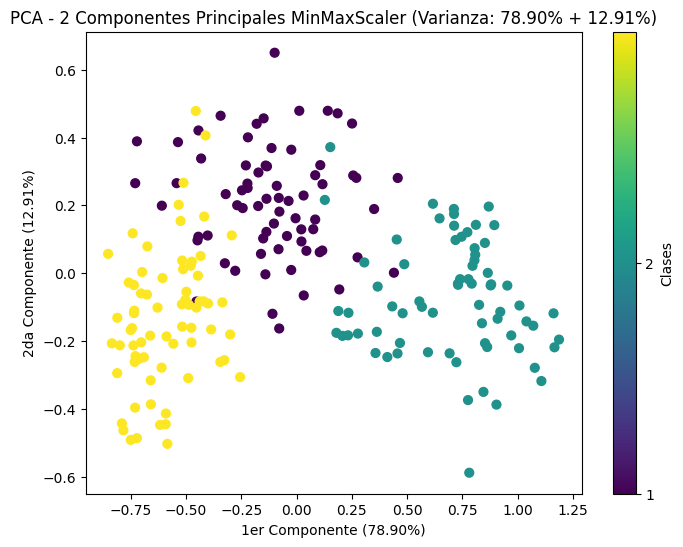

<Figure size 640x480 with 0 Axes>

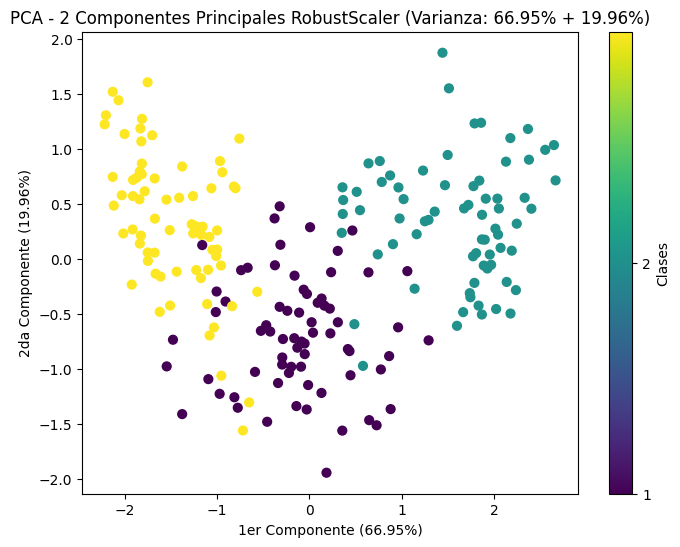

<Figure size 640x480 with 0 Axes>

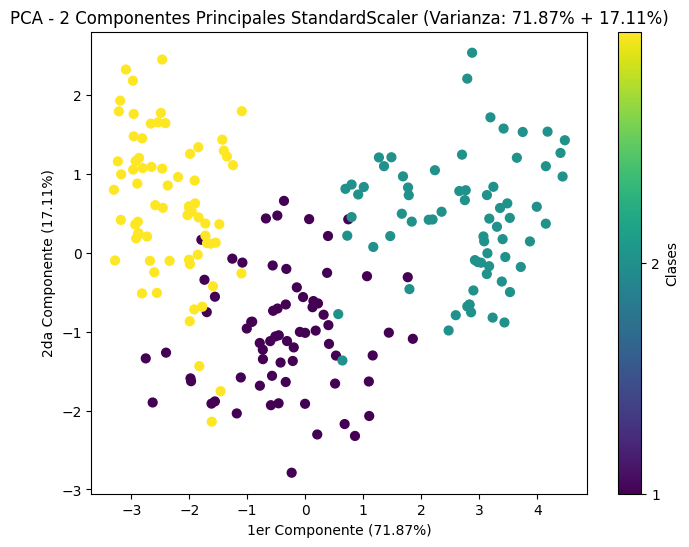

<Figure size 640x480 with 0 Axes>

In [ ]:
# Cargar datos
data = pd.read_csv('semillas.csv')
X = data.drop(columns=["clase"])
Y = data["clase"]
#Para chequear que sea el set de datos correcto
#print(data.head())

# Declaramos los Scalers
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'StandardScaler': StandardScaler()
}

#Definimos que son dos componentes
pca = PCA(n_components=2)

#Creamos las pipelines
X_Reduced = {} # Diccionario para guardar los datos transformados
explained_variance = {}
cumulative_variance = {}

print("\nCreando Pipelines")
for name, scaler in scalers.items():
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', pca)
    ])

    # Ajustar y transformar los datos de características X
    X_Reduced[name] = pipeline.fit_transform(X)
    pca_fitted = pipeline.named_steps['pca']
    # Varianza explicada y acumulada
    explained_variance[name] = pca_fitted.explained_variance_ratio_
    cumulative_variance [name]= np.cumsum(explained_variance[name])
    print(f" -> Pipeline '{name}' completada.\n")
    print(f"    -> Varianza Explicada: {explained_variance[name]}")
    print(f"    -> Varianza Acumulada: {cumulative_variance[name]}\n")

plot_index = 0
for name, data_transformed in X_Reduced.items():
    # Visualizar
    plt.figure(figsize=(8, 6))
    plt.scatter(data_transformed[:, 0], data_transformed[:, 1], c=Y, s=40, cmap='viridis')
    plt.title('PCA - 2 Componentes Principales {} (Varianza: {:.2%} + {:.2%})'.format(name, explained_variance[name][0], explained_variance[name][1]))
    plt.xlabel('1er Componente ({:.2%})'.format(explained_variance[name][0]))
    plt.ylabel('2da Componente ({:.2%})'.format(explained_variance[name][1]))
    plt.colorbar(ticks=range(3), label='Clases')
    plt.show()

    plt.tight_layout()
    plt.show()


En base a los gráficos obtenidos se puede relaizar un análisis visual para determinar la mejor forma de escalado. Pese a que la separación de los grupos
(clusters) en los tre gráficos es similar, en nuestra opinión los clusters más compactos se encuentran en el gráfico de MinMaxScaler. Para confirmar que este es el mejor escalado analizamos los valores de varianza explicada. En estos valores el mayor resultado en la varianza, por más de 7%, fue dado por esta misma forma de escalado. En conclusión, se determinó que los mejores resultados fueron dados por el MinMax Scaler.

# Clustering
Ahora se van a aplicar tres formas de clustering y se analizarán los resultados obtenidos: K-Means, Hierarchical Clustering/Dendrogramas y DBSCAN.



## K-Means
Se va a comenzar con el método de K-Means. Aquí vamos a determinar el número de clusters con ayuda del método "codo" y "silueta".


--- Aplicando K-Means ---

Resultados para los datos escalados con 'MinMaxScaler':


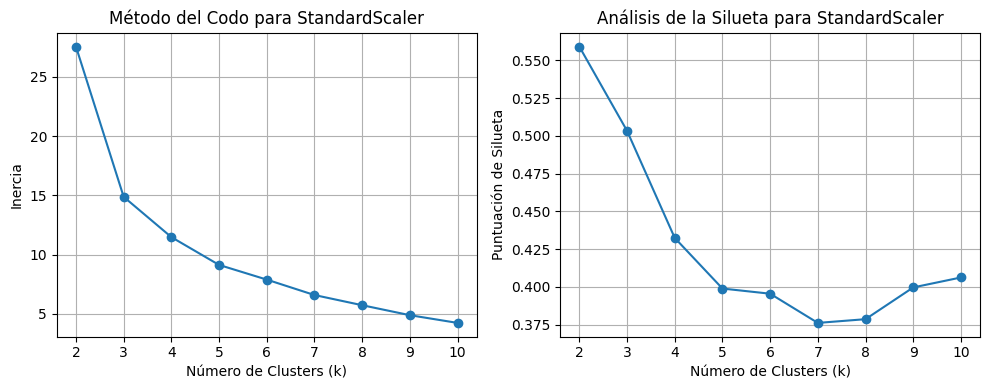


Puntuaciones de codo:
  Número de Clusters: 2, Puntuación: 27.5488
  Número de Clusters: 3, Puntuación: 14.8774
  Número de Clusters: 4, Puntuación: 11.4802
  Número de Clusters: 5, Puntuación: 9.1346
  Número de Clusters: 6, Puntuación: 7.8959
  Número de Clusters: 7, Puntuación: 6.5948
  Número de Clusters: 8, Puntuación: 5.7364
  Número de Clusters: 9, Puntuación: 4.8953
  Número de Clusters: 10, Puntuación: 4.2434

Puntuaciones de Silueta:
  Número de Clusters: 2, Puntuación: 0.5592
  Número de Clusters: 3, Puntuación: 0.5034
  Número de Clusters: 4, Puntuación: 0.4324
  Número de Clusters: 5, Puntuación: 0.3989
  Número de Clusters: 6, Puntuación: 0.3955
  Número de Clusters: 7, Puntuación: 0.3761
  Número de Clusters: 8, Puntuación: 0.3786
  Número de Clusters: 9, Puntuación: 0.3996
  Número de Clusters: 10, Puntuación: 0.4062


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

print("\n--- Aplicando K-Means ---")

n_clusters_range = range(2, 11) # Rango de número de clusters a probar

for name, X_reduced in X_Reduced.items():
  if name == 'MinMaxScaler':
    X_Final = X_reduced
    print(f"\nResultados para los datos escalados con '{name}':")

inertia_values = []
silhouette_scores = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=100495966, n_init=10) # n_init para evitar problemas de convergencia

    # Fit_predict para ambos métodos, método más rápido
    cluster_labels = kmeans.fit_predict(X_Final)

    # Para el método Codo
    inertia_values.append(kmeans.inertia_)

    #Para el método silueta
    silhouette_avg = silhouette_score(X_Final, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Método del codo
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(n_clusters_range, inertia_values, marker='o')
plt.title(f'Método del Codo para {name}')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.xticks(n_clusters_range)
plt.grid(True)

# Método de la silueta
plt.subplot(1, 2, 2)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title(f'Análisis de la Silueta para {name}')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntuación de Silueta')
plt.xticks(n_clusters_range)
plt.grid(True)

plt.tight_layout()
plt.show()

# Imprimir las puntuaciones de codo para facilitar la comparación
print("\nPuntuaciones de codo:")
for i, score in enumerate(inertia_values):
    print(f"  Número de Clusters: {n_clusters_range[i]}, Puntuación: {score:.4f}")

# Imprimir las puntuaciones de silueta para facilitar la comparación
print("\nPuntuaciones de Silueta:")
for i, score in enumerate(silhouette_scores):
    print(f"  Número de Clusters: {n_clusters_range[i]}, Puntuación: {score:.4f}")

AL analizar la gráfica del método "codo", como es de esperarse, la inercia tiende a disminuir a medida que aumentamos el número de clusters. El codo es el punto de la gráfica en el cual la disminución de la inercia comienza a ser más lento, se considera un buen número de clusters el correspondiente a la ubicación del "codo", ya que se considera un punto de equilibrio entre minimizar inercia y no tener exceso de clusters. En este caso, y bajo nuestra opinión, el "codo" se encuentra entre 3 y 4 clusters.

Para analizar con el método silueta se debe analizar la relación entre la putnuación y el número de clusters. La puntuación mide qué tan bien cada muestra se ajusta a su cluster, el número de cluster que maximiza la puntuación se suele considerar la mejor cantidad. En este caso, la puntuación la tuvo cuando se utilizaron 2 clusters.

Utilizando estos dos métodos y promediando los resultados podemos concluir que utilizar 3 clusters es la mejor opción.

Ahora vamos a utilizar un gráfico para ver los clusters:


--- Visualización de Clusters K-Means (MinMaxScaler) ---


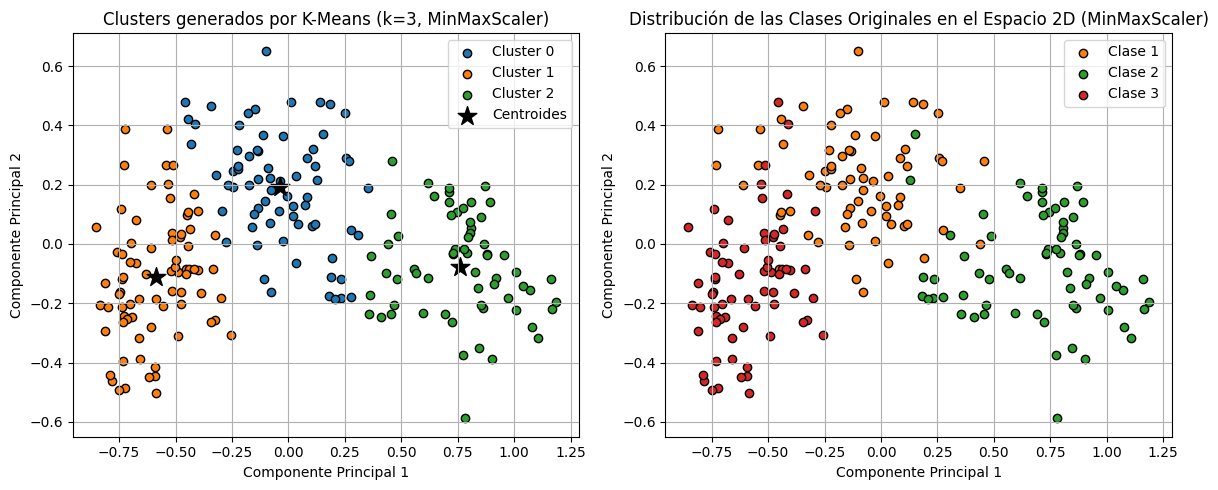

In [ ]:
print("\n--- Visualización de Clusters K-Means (MinMaxScaler) ---")

n_clusters_optimal = 3

# Entrenamos K-Means con el número óptimo de clusters en los datos escalados con MinMaxScaler
kmeans_optimal = KMeans(n_clusters=n_clusters_optimal, random_state=100495966, n_init=10)
cluster_labels_optimal_Kmeans = kmeans_optimal.fit_predict(X_Final)

# Representación gráfica: clusters generados

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Clusters generados por K-means
for i in np.unique(cluster_labels_optimal_Kmeans):
    ax[0].scatter(
        x = X_Final[cluster_labels_optimal_Kmeans == i, 0],
        y = X_Final[cluster_labels_optimal_Kmeans == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

# Centroides de los clusters
ax[0].scatter(
    x = kmeans_optimal.cluster_centers_[:, 0],
    y = kmeans_optimal.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label = 'Centroides'
)

ax[0].set_title(f'Clusters generados por K-Means (k={n_clusters_optimal}, MinMaxScaler)')
ax[0].set_xlabel('Componente Principal 1')
ax[0].set_ylabel('Componente Principal 2')
ax[0].legend()
ax[0].grid(True)

for i in np.unique(Y):
    ax[1].scatter(
        x = X_Final[Y == i, 0],
        y = X_Final[Y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker = 'o',
        edgecolor = 'black',
        label= f"Clase {i}"
    )
ax[1].set_title('Distribución de las Clases Originales en el Espacio 2D (MinMaxScaler)')
ax[1].set_xlabel('Componente Principal 1')
ax[1].set_ylabel('Componente Principal 2')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

Como se puede observar, al aplicar esta técnica tenemos ahora tres clusters mucho mejor definidos.

## Hierarchical Clustering/Dendrogramas

Ahora vamoss a realizar el clustering con la técnica jerárquica. Para esta técnica probaremos diferentes funciones de linkage para determinar el
número de clusters adecuado.


--- Clustering Jerárquico ---
Modelo Average Linkage entrenado.
Modelo Complete Linkage entrenado.
Modelo Ward Linkage entrenado.


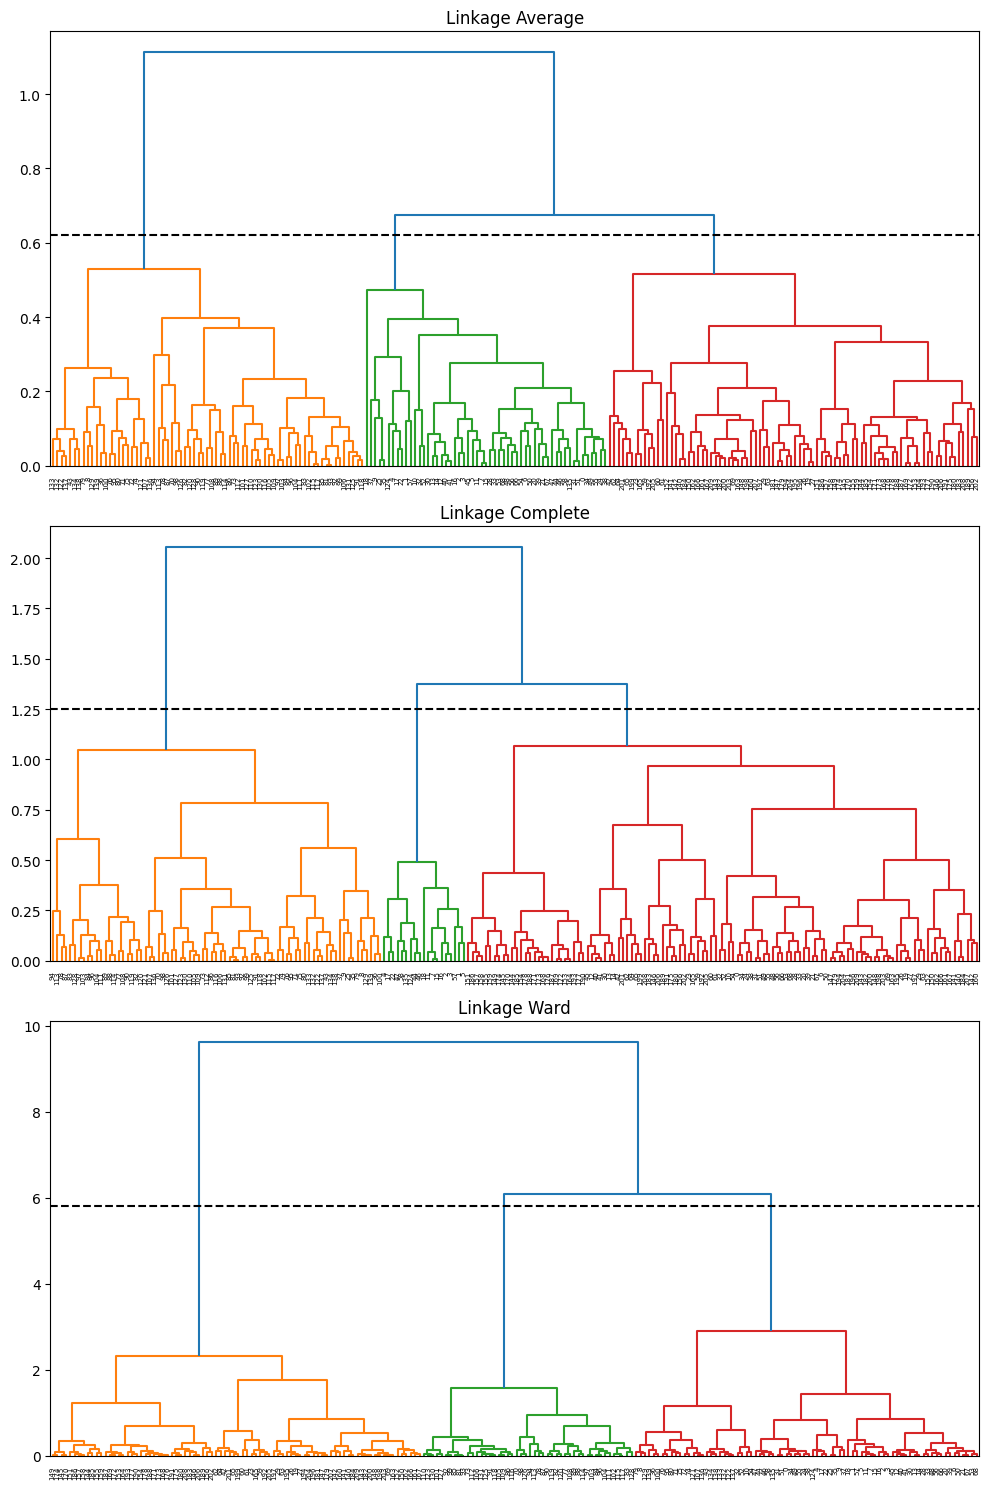

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    # Crear matriz de conteo de hijos
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Crear la matriz de enlace para el dendrograma
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

# Modelos de Clustering Jerárquico
print("\n--- Clustering Jerárquico ---")

# Usaremos los datos reducidos a 2D (X_Final)
X_hclust = X_Final

modelo_hclust_average = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None,
    compute_distances=True # Necesario para la función plot_dendrogram
)
modelo_hclust_average.fit(X=X_hclust)
print("Modelo Average Linkage entrenado.")

modelo_hclust_complete = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None,
    compute_distances=True # Necesario para la función plot_dendrogram
)
modelo_hclust_complete.fit(X=X_hclust)
print("Modelo Complete Linkage entrenado.")

modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None,
    compute_distances=True
)
modelo_hclust_ward.fit(X=X_hclust)
print("Modelo Ward Linkage entrenado.")

# Dendrogramas
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

plot_dendrogram(modelo_hclust_average, labels=np.arange(X_hclust.shape[0]), color_threshold=0.62, ax=axs[0])
axs[0].axhline(y=0.62, c = 'black', linestyle='--', label='altura corte')
axs[0].set_title("Linkage Average")
plot_dendrogram(modelo_hclust_complete, labels=np.arange(X_hclust.shape[0]), color_threshold=1.25, ax=axs[1])
axs[1].axhline(y=1.25, c = 'black', linestyle='--', label='altura corte')
axs[1].set_title("Linkage Complete")
plot_dendrogram(modelo_hclust_ward, labels=np.arange(X_hclust.shape[0]), color_threshold=5.8, ax=axs[2])
axs[2].axhline(y=5.8, c = 'black', linestyle='--', label='altura corte')
axs[2].set_title("Linkage Ward")
plt.tight_layout()
plt.show()


Ahora vamos a analizar los resultado obtenidos. En primer lugar vamos a analizar el dendograma de Average Linkage. En este escenario un corte horizontal que separaría una buena cantidad de ramas principales ocurriría en la altura 0.62, donde tendremos al final 3 clusters. Para el dendograma con Complete Linkage una altura de corte donde los clusters esten relativamente cerca de sí, pero no hayan muchos de ellos ocurre en 1.25. Aquí tendríamos 3 clusters. En el dendograma de Ward Linkage podemos concluir que un poco antes de altura 6 hay una unión de ramas muy importantes, donde tendremos 3 clusters. Con esto podemos hacernos una idea de la cantidad de cluster que podría ser ideal para este escenario. Para confirmar que estamos haciendo un análisis visual correct, vamos a utilizar un código que nos permite calcular el posible mejor punto de corte en base a los saltos que hay en el dendograma.


--- Análisis del Dendrograma para Número Óptimo de Clusters (Por Linkage) ---

--- Linkage: Average ---
Número óptimo de clusters (Dendrograma): 2
Altura de fusión óptima: 0.67


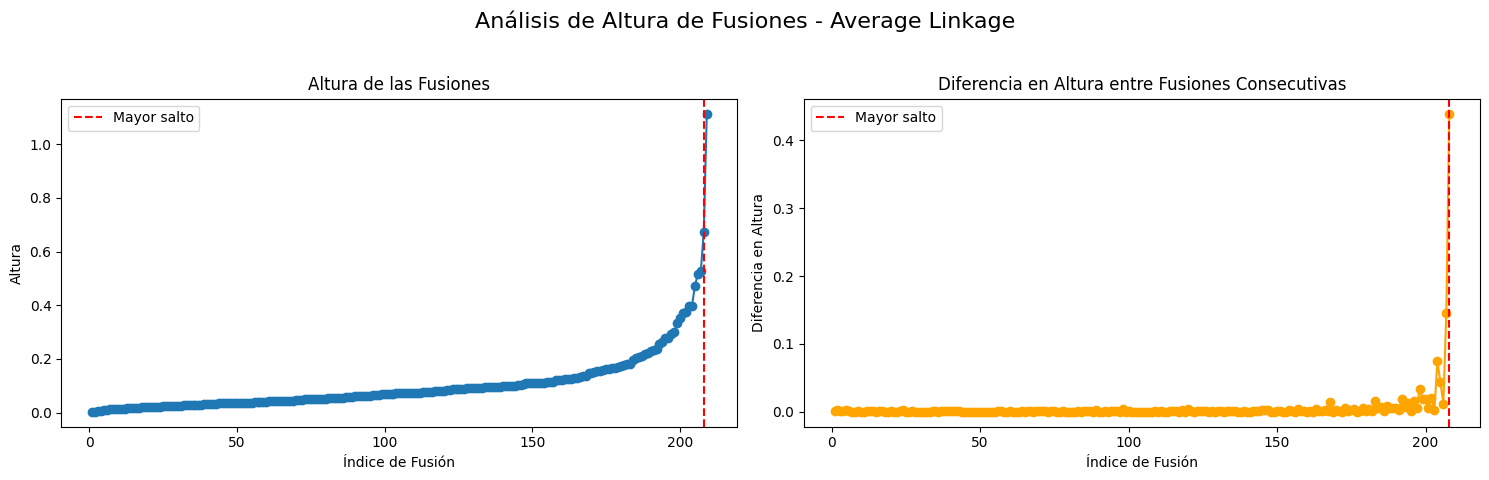

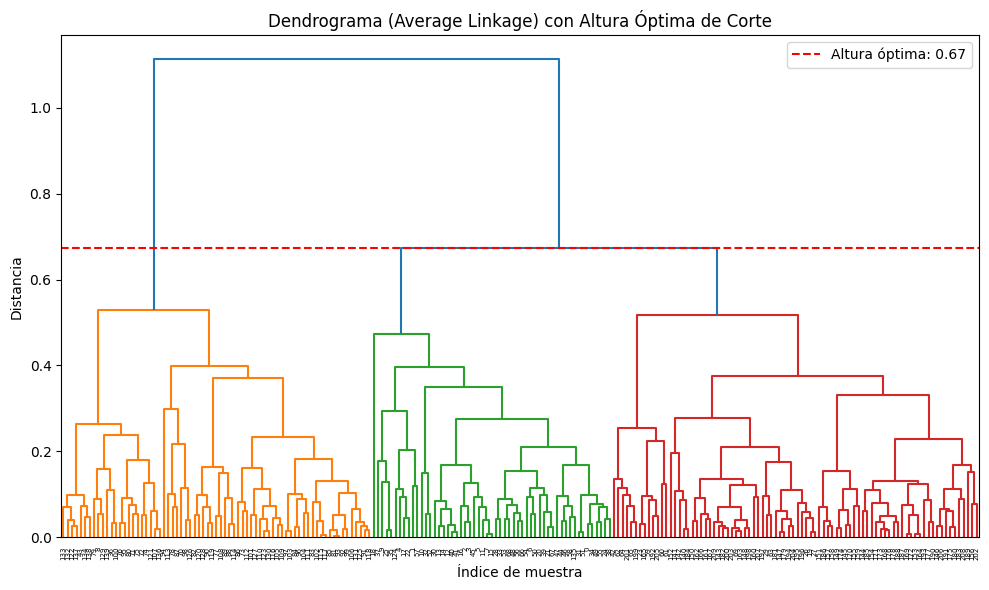


--- Linkage: Complete ---
Número óptimo de clusters (Dendrograma): 2
Altura de fusión óptima: 1.37


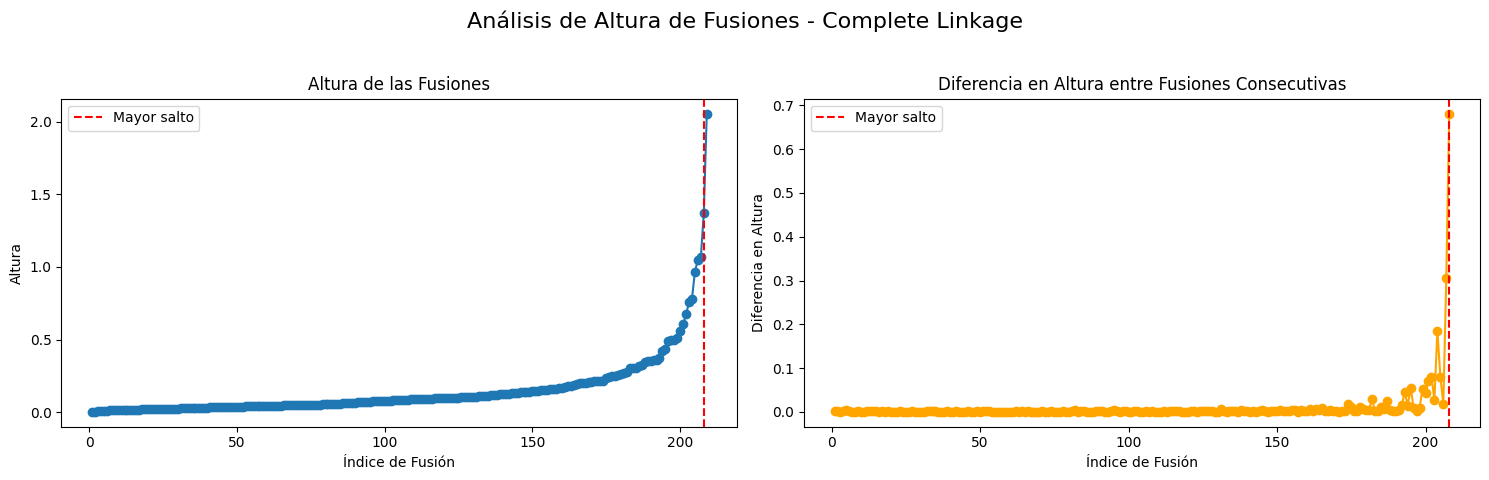

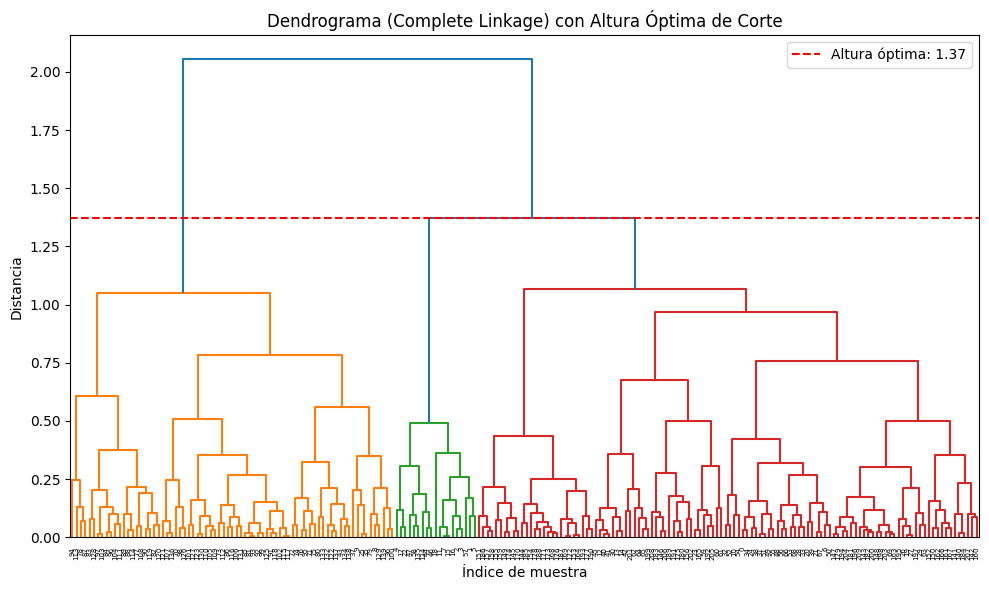


--- Linkage: Ward ---
Número óptimo de clusters (Dendrograma): 2
Altura de fusión óptima: 6.09


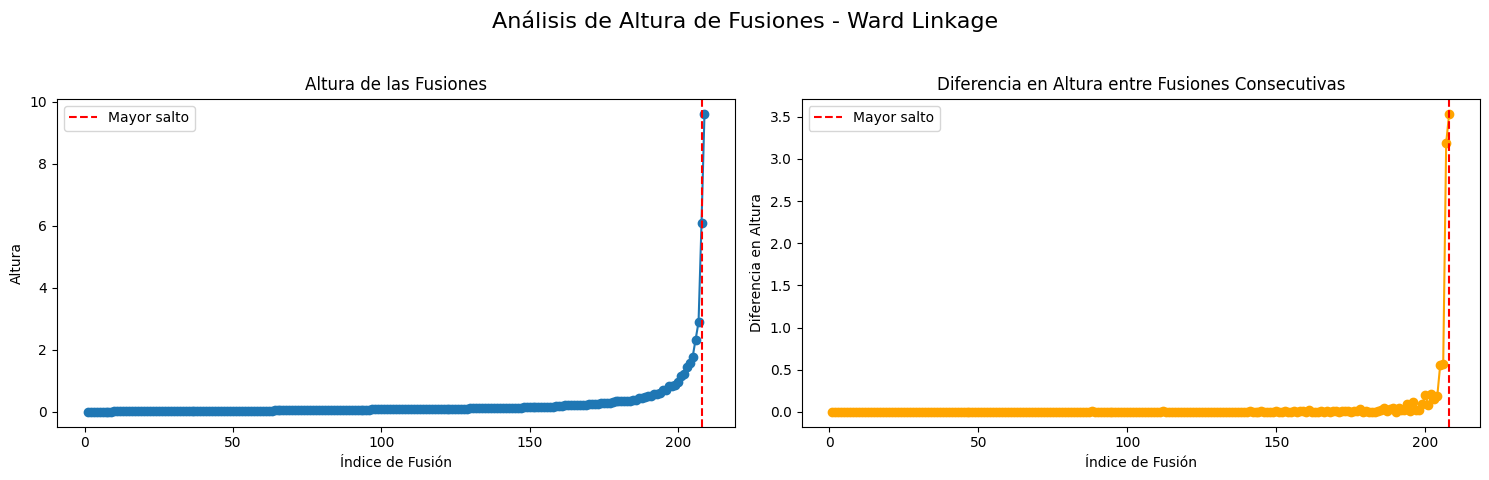

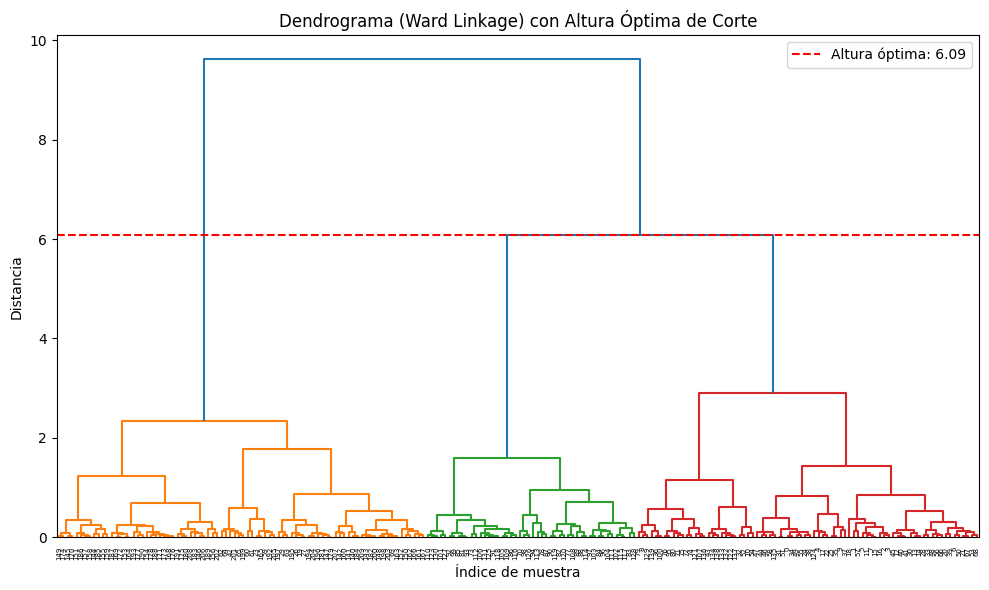

In [ ]:

linkage_methods = ['average', 'complete', 'ward']

print("\n--- Análisis del Dendrograma para Número Óptimo de Clusters (Por Linkage) ---")

for i, method in enumerate(linkage_methods):
    # Calculamos la matriz de enlace usando scipy
    Z = linkage(X_hclust, method=method)

    # Extraemos las alturas de fusión
    heights = Z[:, 2]

    # Calculamos las diferencias entre alturas consecutivas
    diffs = np.diff(heights)

    # Índice donde ocurre el mayor salto en altura
    idx_max_jump = np.argmax(diffs)

    # Número óptimo de clusters basado en el mayor salto
    n_clusters_optimo_dendro = len(heights) - idx_max_jump

    # Altura de fusión óptima
    altura_optima = heights[idx_max_jump]

    print(f"\n--- Linkage: {method.capitalize()} ---")
    print(f"Número óptimo de clusters (Dendrograma): {n_clusters_optimo_dendro}")
    print(f"Altura de fusión óptima: {altura_optima:.2f}")

    # Graficamos la altura de fusión y su incremento
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Análisis de Altura de Fusiones - {method.capitalize()} Linkage", fontsize=16)

    # Gráfico de las alturas de fusión
    axs[0].plot(range(1, len(heights) + 1), heights, marker='o', linestyle='-')
    axs[0].set_title("Altura de las Fusiones")
    axs[0].set_xlabel("Índice de Fusión")
    axs[0].set_ylabel("Altura")
    axs[0].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
    axs[0].legend()

    # Gráfico del incremento en altura
    axs[1].plot(range(1, len(diffs) + 1), diffs, marker='o', linestyle='-', color='orange')
    axs[1].set_title("Diferencia en Altura entre Fusiones Consecutivas")
    axs[1].set_xlabel("Índice de Fusión")
    axs[1].set_ylabel("Diferencia en Altura")
    axs[1].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
    axs[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste para el título general
    plt.show()

    # Graficamos el dendrograma con la altura óptima de corte
    plt.figure(figsize=(10, 6))
    dendrogram(Z, color_threshold=altura_optima)
    plt.axhline(y=altura_optima, color='r', linestyle='dashed', label=f'Altura óptima: {altura_optima:.2f}')
    plt.title(f"Dendrograma ({method.capitalize()} Linkage) con Altura Óptima de Corte")
    plt.xlabel("Índice de muestra")
    plt.ylabel("Distancia")
    plt.legend()
    plt.tight_layout()
    plt.show()

 Este anáisis, a diferencia de nuestro análisis visual, concluyó que el mejor número de cluster para los tres tipos, es 2. Sin embargo, para confirmar el número final que utilizaremos, analizaremos los resultados mediante la técnica de silueta.


--- Análisis de Silueta para Diferentes Linkages ---

Puntuaciones de Silueta (Ward Linkage):
  Número de Clusters: 2, Puntuación: 0.4654
  Número de Clusters: 3, Puntuación: 0.4714
  Número de Clusters: 4, Puntuación: 0.4451
  Número de Clusters: 5, Puntuación: 0.3850
  Número de Clusters: 6, Puntuación: 0.3958
  Número de Clusters: 7, Puntuación: 0.3690
  Número de Clusters: 8, Puntuación: 0.3635
  Número de Clusters: 9, Puntuación: 0.3708
  Número de Clusters: 10, Puntuación: 0.3765

Puntuaciones de Silueta (Average Linkage):
  Número de Clusters: 2, Puntuación: 0.5531
  Número de Clusters: 3, Puntuación: 0.4752
  Número de Clusters: 4, Puntuación: 0.4420
  Número de Clusters: 5, Puntuación: 0.4001
  Número de Clusters: 6, Puntuación: 0.3743
  Número de Clusters: 7, Puntuación: 0.3484
  Número de Clusters: 8, Puntuación: 0.3550
  Número de Clusters: 9, Puntuación: 0.3510
  Número de Clusters: 10, Puntuación: 0.3739

Puntuaciones de Silueta (Complete Linkage):
  Número de Clusters: 

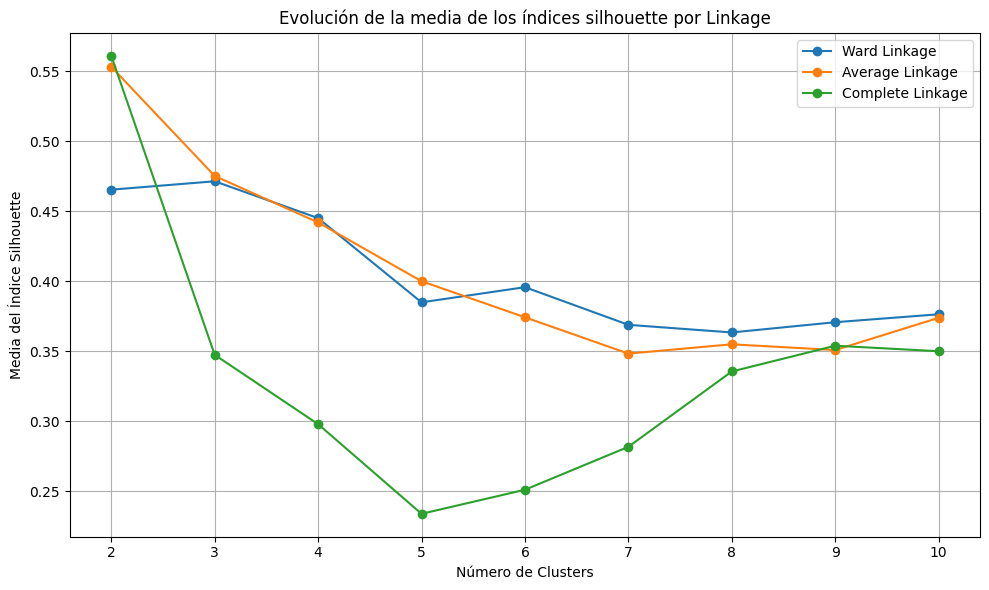

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


# Rango de número de clusters a probar
range_n_clusters = range(2, 11)

# Métodos de linkage a probar
linkage_methods = ['ward', 'average', 'complete']
silhouette_scores_all = {}


for linkage in linkage_methods:
    valores_medios_silhouette = []
    for n_clusters in range_n_clusters:
        modelo = AgglomerativeClustering(
            n_clusters = n_clusters,
            linkage    = linkage
        )
        cluster_labels = modelo.fit_predict(X_hclust)
        silhouette_avg = silhouette_score(X_hclust, cluster_labels)
        valores_medios_silhouette.append(silhouette_avg)
    silhouette_scores_all[linkage] = valores_medios_silhouette
    print(f"\nPuntuaciones de Silueta ({linkage.capitalize()} Linkage):")
    for i, score in enumerate(valores_medios_silhouette):
        print(f"  Número de Clusters: {range_n_clusters[i]}, Puntuación: {score:.4f}")

# Graficar las puntuaciones de silueta para cada linkage
fig, ax = plt.subplots(figsize=(10, 6))
for linkage, scores in silhouette_scores_all.items():
    ax.plot(range_n_clusters, scores, marker='o', label=f'{linkage.capitalize()} Linkage')

ax.set_title("Evolución de la media de los índices silhouette por Linkage")
ax.set_xlabel('Número de Clusters')
ax.set_ylabel('Media del Índice Silhouette')
ax.set_xticks(range_n_clusters)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

Aquí se puede observar que estos serían los números ideales de clusters para cada método de linkage:

*   Complete: 2 clusters
*   Average: 2 clusters
*   Ward: 3 clusters

El número obtenido mediante el método silueta es igual a lo analizado con Ward Linkage y muy similar con Complete Linkage y Average Linkage.

Mediante este análisis concluimos que el mejor resultado obtenido fue dado con complete linkage y 2 clusters; esta va a ser la combinación que utilizaremos.





--- Visualización de Clusters Jerárquicos (Complete Linkage, k=2) ---


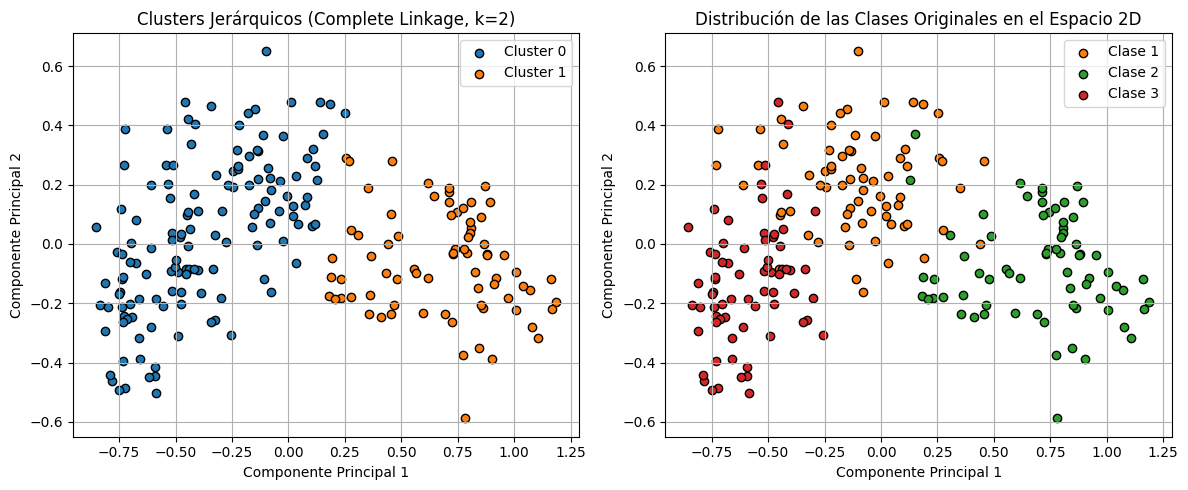

In [ ]:
print("\n--- Visualización de Clusters Jerárquicos (Complete Linkage, k=2) ---")

# Número óptimo de clusters según el análisis de silueta
n_clusters_optimal = 2
linkage_method = 'complete'

# Entrenamos el modelo de Clustering Jerárquico
hclust_optimal = AgglomerativeClustering(n_clusters=n_clusters_optimal, linkage=linkage_method)
cluster_labels_optimal_hclust = hclust_optimal.fit_predict(X_hclust)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Clusters generados por Clustering Jerárquico
for i in np.unique(cluster_labels_optimal_hclust):
    ax[0].scatter(
        x = X_hclust[cluster_labels_optimal_hclust == i, 0],
        y = X_hclust[cluster_labels_optimal_hclust == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[0].set_title(f'Clusters Jerárquicos ({linkage_method.capitalize()} Linkage, k={n_clusters_optimal})')
ax[0].set_xlabel('Componente Principal 1')
ax[0].set_ylabel('Componente Principal 2')
ax[0].legend()
ax[0].grid(True)

# Distribución de las Clases Originales (en el segundo subplot: ax[1])
for i in np.unique(Y):
    ax[1].scatter(
        x = X_hclust[Y == i, 0],
        y = X_hclust[Y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker = 'o',
        edgecolor = 'black',
        label= f"Clase {i}"
    )
ax[1].set_title('Distribución de las Clases Originales en el Espacio 2D')
ax[1].set_xlabel('Componente Principal 1')
ax[1].set_ylabel('Componente Principal 2')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

## DBSCAN
Ahora aplicaremos el método de DBSCAN con diferentes minpts y eps. Primero, vamos a utilizar un gráfico para determinar los mejores eps para este método.

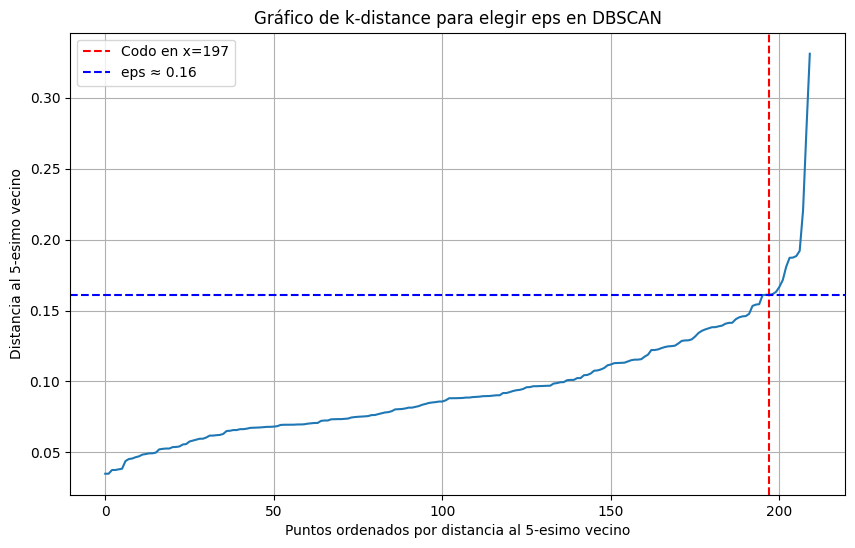

x_point=197 y_value=0.161055112902818

Valor de epsilon sugerido: 0.16


In [ ]:
from sklearn.neighbors import NearestNeighbors

min_samples = 5
X_DBSCAN = X_Final

# Compute the nearest neighbors
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_DBSCAN)
distances, indices = nn.kneighbors(X_DBSCAN)

# Sort the distances
sorted_distances = np.sort(distances[:, min_samples-1], axis=0)

x_point = 197
y_value = sorted_distances[x_point]  # Obtener el valor de la distancia para ese punto

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.xlabel(f'Puntos ordenados por distancia al {min_samples}-esimo vecino')
plt.ylabel(f'Distancia al {min_samples}-esimo vecino')
plt.title('Gráfico de k-distance para elegir eps en DBSCAN')

plt.axvline(x=x_point, color='r', linestyle='--', label=f'Codo en x={x_point}')
plt.axhline(y=y_value, color='b', linestyle='--', label=f'eps ≈ {y_value:.2f}')

plt.grid(True)
plt.legend()
plt.show()

print(f'{x_point=} y_value={y_value}')

# Ahora puedes usar este valor de y_value como tu valor de 'eps' en DBSCAN
optimal_eps = y_value
print(f'\nValor de epsilon sugerido: {optimal_eps:.2f}')

En base a lo obtenido se sugiere probar un valor de epsilon similar a 0.16.


--- Evaluación de DBSCAN con Diferentes Valores de Epsilon y MinSamples ---

Resultados de DBSCAN para diferentes valores de epsilon y min_samples:
Epsilon: 0.08, MinSamples: 4, Número de Clusters: 7, Puntuación de Silueta: 0.0552
Epsilon: 0.08, MinSamples: 5, Número de Clusters: 8, Puntuación de Silueta: 0.0163
Epsilon: 0.08, MinSamples: 10, Número de Clusters: 1, Puntuación de Silueta: -1.0000
Epsilon: 0.12, MinSamples: 4, Número de Clusters: 3, Puntuación de Silueta: 0.3529
Epsilon: 0.12, MinSamples: 5, Número de Clusters: 3, Puntuación de Silueta: 0.3348
Epsilon: 0.12, MinSamples: 10, Número de Clusters: 3, Puntuación de Silueta: 0.1968
Epsilon: 0.16, MinSamples: 4, Número de Clusters: 1, Puntuación de Silueta: -1.0000
Epsilon: 0.16, MinSamples: 5, Número de Clusters: 1, Puntuación de Silueta: -1.0000
Epsilon: 0.16, MinSamples: 10, Número de Clusters: 2, Puntuación de Silueta: 0.2905
Epsilon: 0.20, MinSamples: 4, Número de Clusters: 1, Puntuación de Silueta: -1.0000
Epsilon: 0.20,

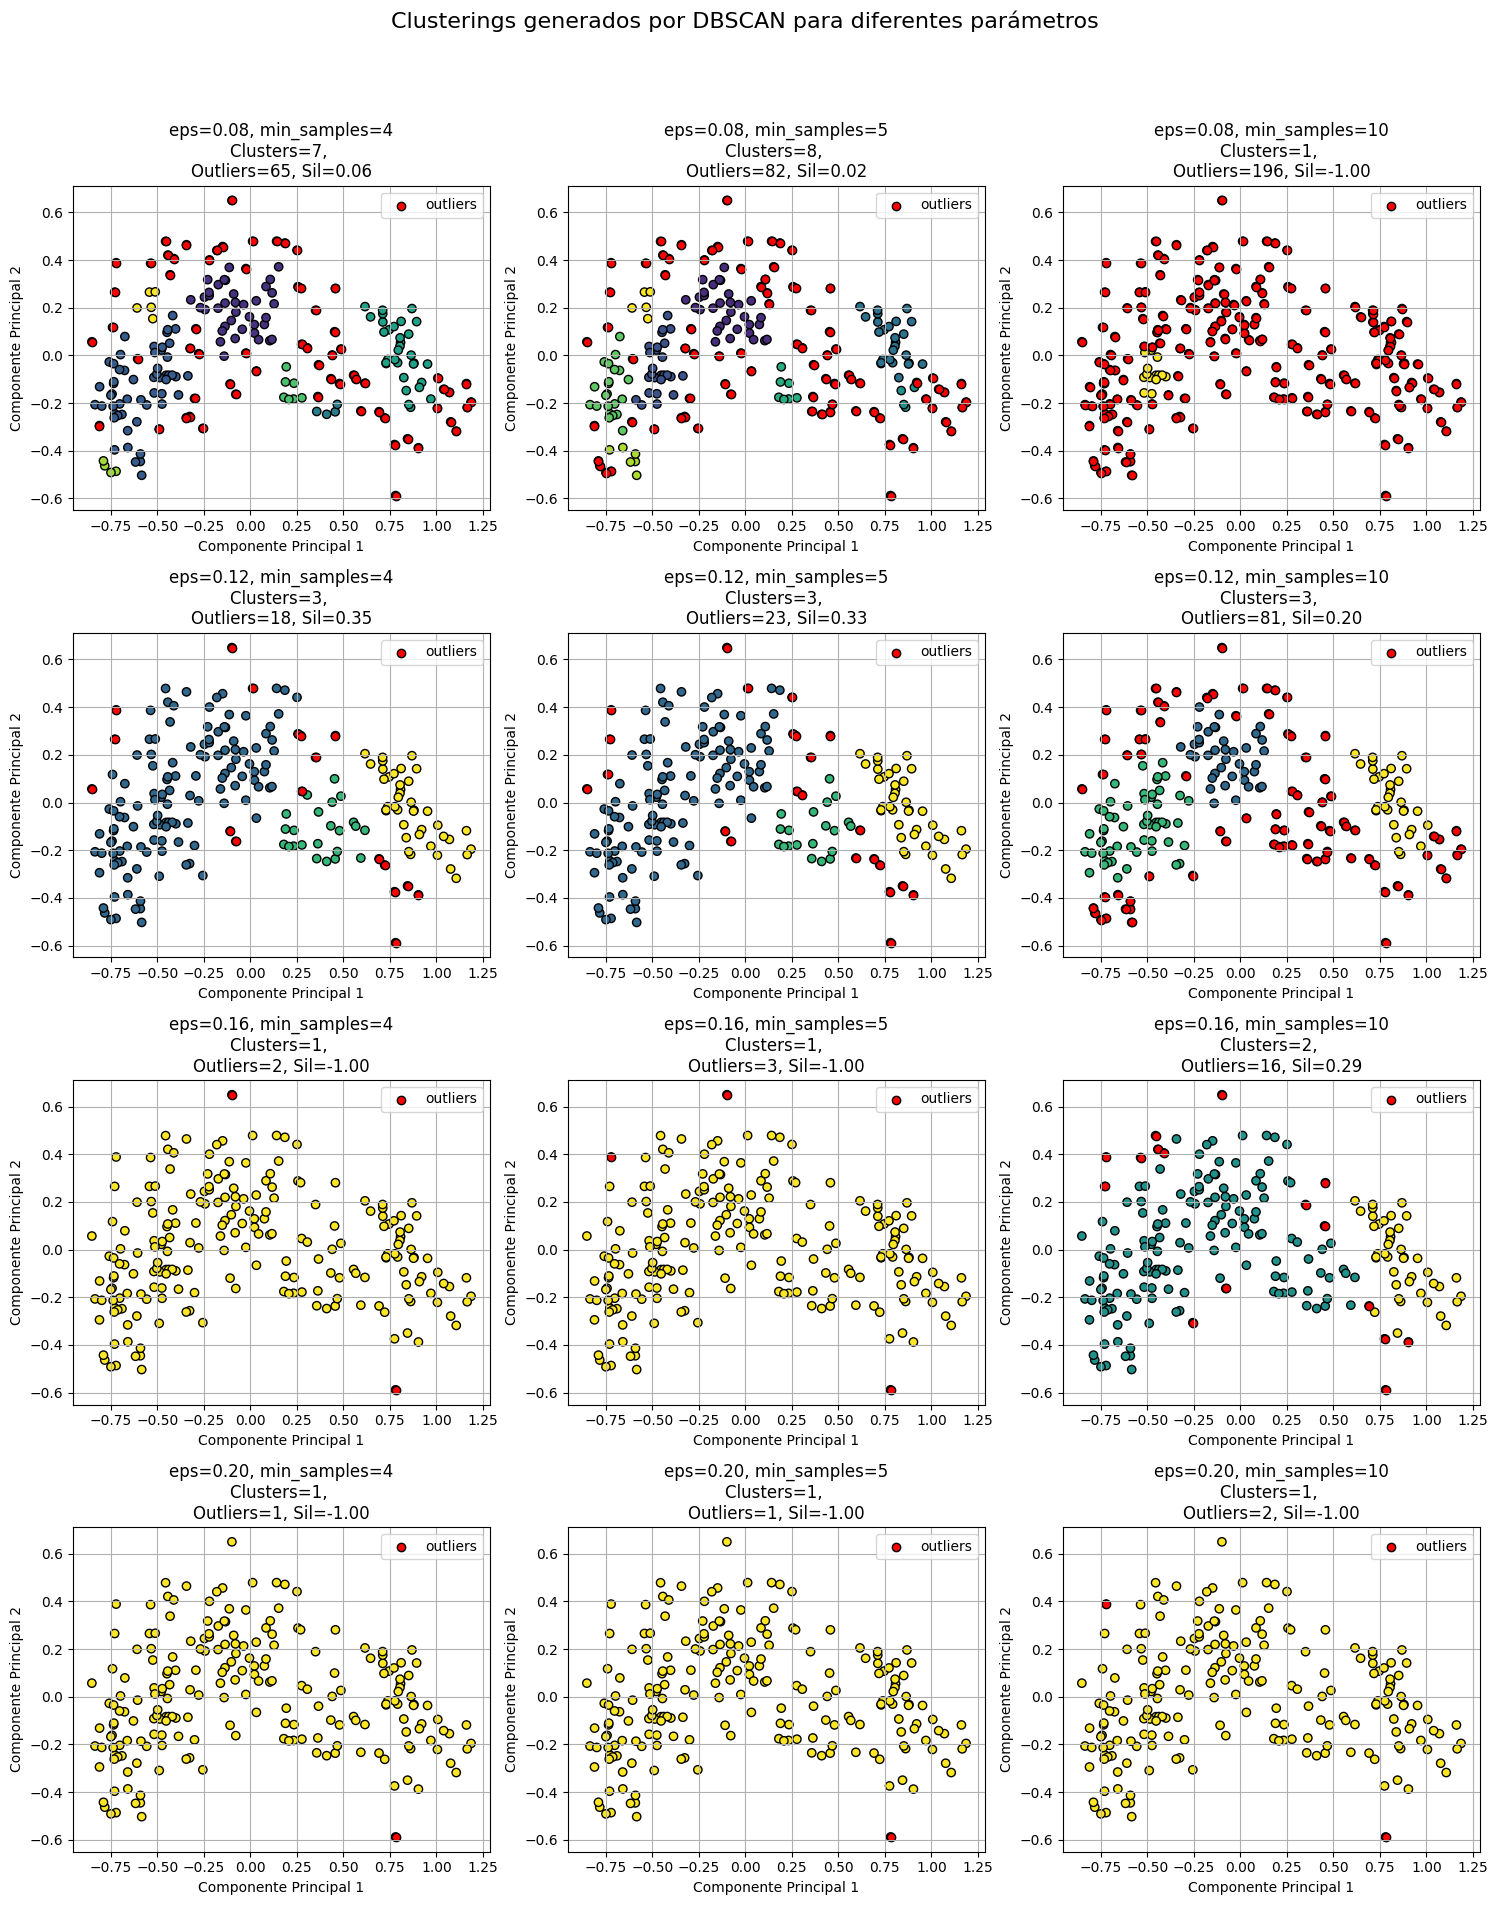

In [ ]:
from sklearn.cluster import DBSCAN

print("\n--- Evaluación de DBSCAN con Diferentes Valores de Epsilon y MinSamples ---")

# Rango de valores de epsilon a probar, incluyendo el recomendado
eps_range = [0.08, 0.12, 0.16, 0.20]
min_samples_list = [4, 5, 10] # Lista de valores de min_samples a probar

results = []

# Crear una figura con subplots para las visualizaciones
num_eps = len(eps_range)
num_min_samples = len(min_samples_list)
fig, axes = plt.subplots(num_eps, num_min_samples, figsize=(5 * num_min_samples, 5 * num_eps))
fig.suptitle('Clusterings generados por DBSCAN para diferentes parámetros', fontsize=16)

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_samples_list):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_DBSCAN)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)

        silhouette_avg = -1 # Valor por defecto si no hay suficientes clusters
        if n_clusters > 1:
            silhouette_avg = silhouette_score(X_DBSCAN, cluster_labels)

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_avg,
            'labels': cluster_labels
        })

        ax = axes[i, j]
        ax.scatter(
            x = X_DBSCAN[:, 0],
            y = X_DBSCAN[:, 1],
            c = cluster_labels,
            marker = 'o',
            edgecolor = 'black',
            cmap='viridis' # Puedes probar otros colormaps
        )

        # Los outliers se identifican con el label -1
        outliers = X_DBSCAN[cluster_labels == -1]
        ax.scatter(
            x = outliers[:, 0],
            y = outliers[:, 1],
            c = 'red',
            marker = 'o',
            edgecolor = 'black',
            label = 'outliers'
        )

        ax.set_title(f'eps={eps:.2f}, min_samples={min_samples}\nClusters={n_clusters}, \nOutliers={n_noise}, Sil={silhouette_avg:.2f}')
        ax.set_xlabel('Componente Principal 1')
        ax.set_ylabel('Componente Principal 2')
        ax.legend(loc='upper right')
        ax.grid(True)

print("\nResultados de DBSCAN para diferentes valores de epsilon y min_samples:")
for result in results:
    print(f"Epsilon: {result['eps']:.2f}, MinSamples: {result['min_samples']}, Número de Clusters: {result['n_clusters']}, Puntuación de Silueta: {result['silhouette_score']:.4f}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para el título general
plt.show()

Estos resultados muestran que con un eps mayor 0.16, gracias a la vecinidad de los datos, estos suelen empezar a agruparse en un solo cluster. En términos generales los mejores resultados obtenidos sucedieron con un eps de 0.12. Dentro de esta distancia, se probaron tres posibilidades de mínimo de muestras para crear cluster. Con 10 muestras, terminamos con demasiados outliers, y con  3 muestras terminamos con un cluster con tan solo tres elementos. Pese a tener un mayor número de outliers, el mejor resultado obtenido fue con eps= 0.12 y 5 como mínmo de puntos. Como una prueba extra, se decidió probar con 4 en el número mínmo de puntos y este dio un mejor resultado que 3. Por este motivo, lo cambiamos por el 3, y ahora la combinación a elegir va a ser 0.12 de eps, y 4 de mínimo de muestra, lo cual genera 3 clusters.

Resultados de DBSCAN:
  Epsilon (eps): 0.12
  MinSamples: 4
  Número de clusters encontrados: 3
  Número de puntos considerados ruido: 18


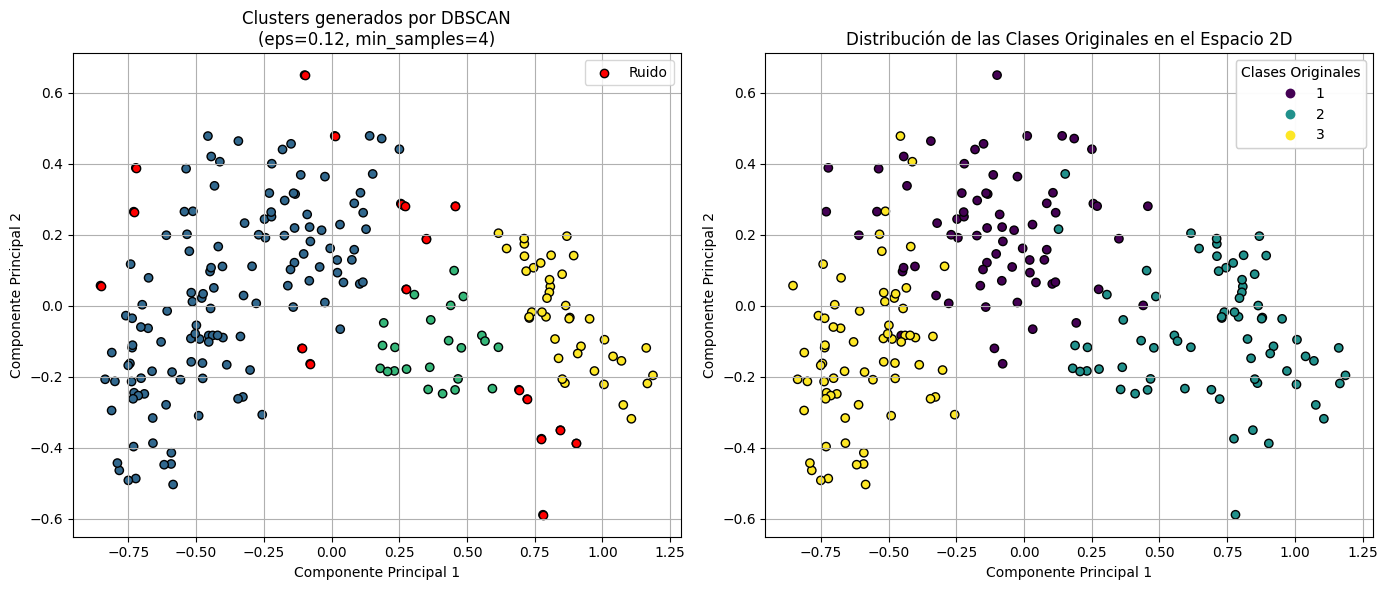

In [ ]:
# Hiperparámetros definidos por el usuario
optimal_eps = 0.12
min_samples = 4

# Aplicar DBSCAN con los hiperparámetros definidos
dbscan_optimal = DBSCAN(eps=optimal_eps, min_samples=min_samples)
cluster_labels_optimal = dbscan_optimal.fit_predict(X_DBSCAN)
n_clusters_optimal = len(set(cluster_labels_optimal)) - (1 if -1 in cluster_labels_optimal else 0)
n_noise_points = np.sum(cluster_labels_optimal == -1)

print(f'Resultados de DBSCAN:')
print(f'  Epsilon (eps): {optimal_eps:.2f}')
print(f'  MinSamples: {min_samples}')
print(f'  Número de clusters encontrados: {n_clusters_optimal}')
print(f'  Número de puntos considerados ruido: {n_noise_points}')

# Visualizar los clusters generados por DBSCAN y la distribución original
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Clusters generados por DBSCAN
scatter_dbscan = axes[0].scatter(
    x = X_DBSCAN[:, 0],
    y = X_DBSCAN[:, 1],
    c = cluster_labels_optimal,
    marker = 'o',
    edgecolor = 'black',
    cmap='viridis'
)
axes[0].set_title(f'Clusters generados por DBSCAN\n(eps={optimal_eps:.2f}, min_samples={min_samples})')
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')

# Graficar los outliers en rojo
outliers_dbscan = X_DBSCAN[cluster_labels_optimal == -1]
axes[0].scatter(
    x = outliers_dbscan[:, 0],
    y = outliers_dbscan[:, 1],
    c = 'red',
    marker = 'o',
    edgecolor = 'black',
    label = 'Ruido'
)
axes[0].legend(loc='upper right')
axes[0].grid(True)

# Subplot 2: Distribución de las Clases Originales
scatter_original = axes[1].scatter(
    x = X_DBSCAN[:, 0],
    y = X_DBSCAN[:, 1],
    c = Y,
    marker = 'o',
    edgecolor = 'black',
    cmap='viridis'
)
axes[1].set_title('Distribución de las Clases Originales en el Espacio 2D')
axes[1].set_xlabel('Componente Principal 1')
axes[1].set_ylabel('Componente Principal 2')

# Crear leyenda para las clases originales
legend_original = axes[1].legend(*scatter_original.legend_elements(), title="Clases Originales")
axes[1].add_artist(legend_original)
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Análisis de resultados
Ahora se va definir cuál es el método de clustering más adecuado para el problema, y cuál es su relación con las semillas originales. Para lograr esto, va aser pertientne volver a gráficar los clusters resultantes de cada método, uno al lado del otro.


--- Comparación Visual de Resultados de Clustering ---


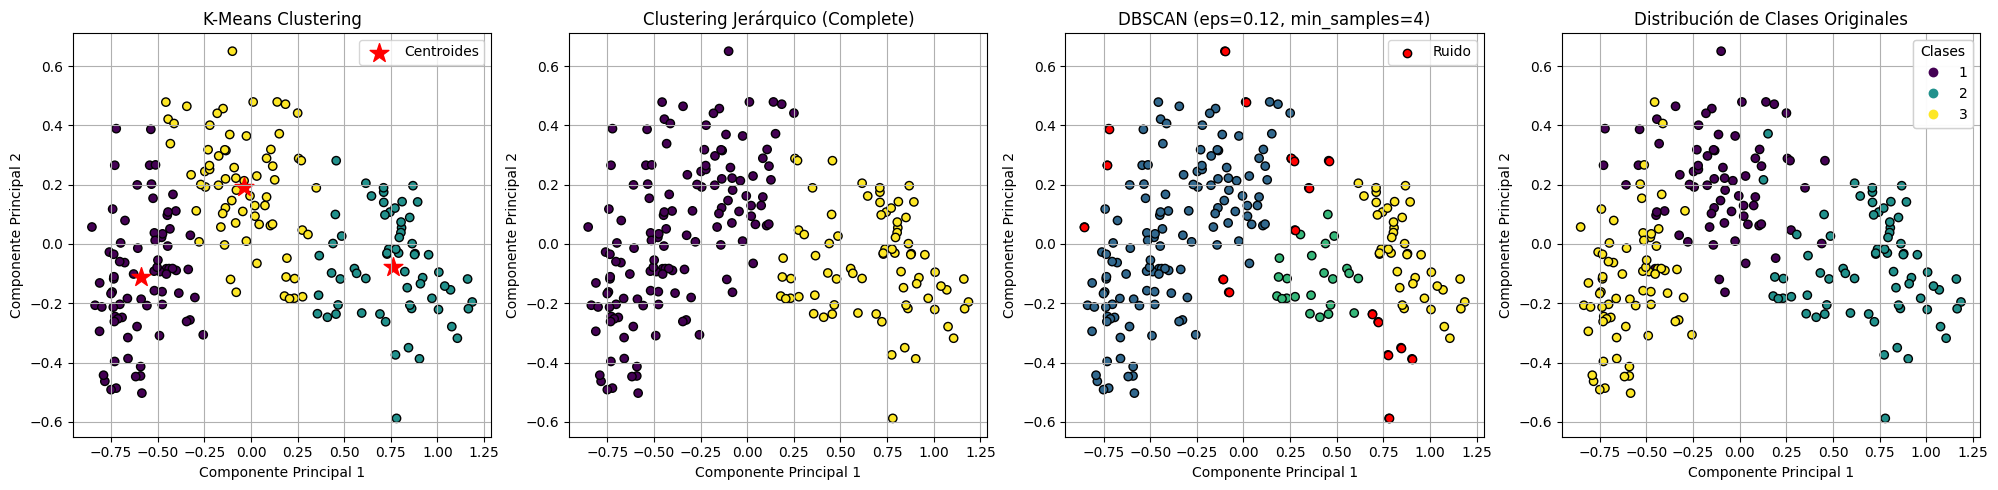

In [ ]:

print("\n--- Comparación Visual de Resultados de Clustering ---")

# Número de clusters K-Means Clustering
n_clusters_Kmeans = 3

# Número de clusters Agglomerative Clustering
n_clusters_Agglo = 2

# Hiperparámetros para DBSCAN
optimal_eps = 0.12
min_samples_dbscan = 4

# Entrenar los modelos
kmeans = KMeans(n_clusters=n_clusters_Kmeans, random_state=42, n_init= 10)
kmeans_labels = kmeans.fit_predict(X_Final)
kmeans_centroids = kmeans.cluster_centers_

hclust = AgglomerativeClustering(n_clusters=n_clusters_Agglo, linkage='complete')
hclust_labels = hclust.fit_predict(X_hclust)

dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples_dbscan)
dbscan_labels = dbscan.fit_predict(X_DBSCAN)

# Crear la figura con 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
cmap = 'viridis'

# K-Means
scatter_kmeans = axes[0].scatter(X_Final[:, 0], X_Final[:, 1], c=kmeans_labels, cmap=cmap, edgecolor='black')
axes[0].scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='*', s=200, color='red', label='Centroides')
axes[0].set_title('K-Means Clustering')
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')
axes[0].legend()
axes[0].grid(True)

#  Clustering Jerárquico (Complete Linkage)
scatter_hclust = axes[1].scatter(X_hclust[:, 0], X_hclust[:, 1], c=hclust_labels, cmap=cmap, edgecolor='black')
axes[1].set_title('Clustering Jerárquico (Complete)')
axes[1].set_xlabel('Componente Principal 1')
axes[1].set_ylabel('Componente Principal 2')
axes[1].grid(True)

# DBSCAN
scatter_dbscan = axes[2].scatter(X_DBSCAN[:, 0], X_DBSCAN[:, 1], c=dbscan_labels, cmap=cmap, edgecolor='black')
# Graficar los outliers en rojo
outliers_dbscan = X_DBSCAN[dbscan_labels == -1]
axes[2].scatter(outliers_dbscan[:, 0], outliers_dbscan[:, 1], c='red', marker='o', edgecolor='black', label='Ruido')
axes[2].set_title(f'DBSCAN (eps={optimal_eps:.2f}, min_samples={min_samples_dbscan})')
axes[2].set_xlabel('Componente Principal 1')
axes[2].set_ylabel('Componente Principal 2')
axes[2].legend()
axes[2].grid(True)

# Distribución de las Clases Originales
scatter_original = axes[3].scatter(X_Final[:, 0], X_Final[:, 1], c=Y, cmap=cmap, edgecolor='black')
axes[3].set_title('Distribución de Clases Originales')
axes[3].set_xlabel('Componente Principal 1')
axes[3].set_ylabel('Componente Principal 2')
legend_original = axes[3].legend(*scatter_original.legend_elements(), title="Clases", loc='upper right')
axes[3].add_artist(legend_original)
axes[3].grid(True)

plt.tight_layout()
plt.show()


Pese a que todos los resultados finales se ven relativamente correctos, visualmente el que caputra más la estructura del problema es el realizado con el método de K-Means. En este se pueden apreciar grupos más compactos que recojen los puntos de una forma similar a la distribución original.

En relación a qué tanto se asemejan los clusters a las clases de semillas originales, podemos apreciar que existe una relación.

Para el clustering jerárquico pese a que tenemos dos grupos en lugar de los tres originales podemos ver que se releaciona ya que el tipo se semilla 3 y segundo cluster son casi idénticos. Mientras que las semillas 1 y 2 fueron recojidad en un mismo cluster, posiblimetne dado que se enccontró una similitud entra ambos tipos. En pocas palabras, pese a tener un número diferente de clusters, este parece sguir una tendencia similar y a respresentar bien el caso original.

Por el otro lado, los otros dos métodos nos dieron un resultado que tiene el mismo número de clusters que el grupo original, lo cuál puede facilitar su semejanza. El primero a analizar es realizado por medio de DBSCAN. En este se pueden apreciar tres clusters, sin embargo estos tienen una forma muy distinta a la original. El cluster azul parece haber recopilado las semillas de clase 1 y 3. Mientras que el las semillas de clase 2 se dividieron en los dos clustering restantes.

Finalemente, en el método de K-Means, que en nuestra opinión es el que mejor representa la estructura del problema, se ppuede apreciar claramente una semenjanzas. Los clusters generados por este método son realemnte similares a los grupos originales. La semilla de tipo 2 es representada casi perfectamente por el cluster verde-azul. La semilla 1 pese a tner un par de errores, es representada por el cluster amarillo. Y la semilla 3 es reoresentada por el cluster morado. Este método logra claramente representar el problema y también permite crear grupos compactos que agrupan los puntos originales con una buena certeza.


--- Boxplots de Variables Originales por Cluster de K-Means ---


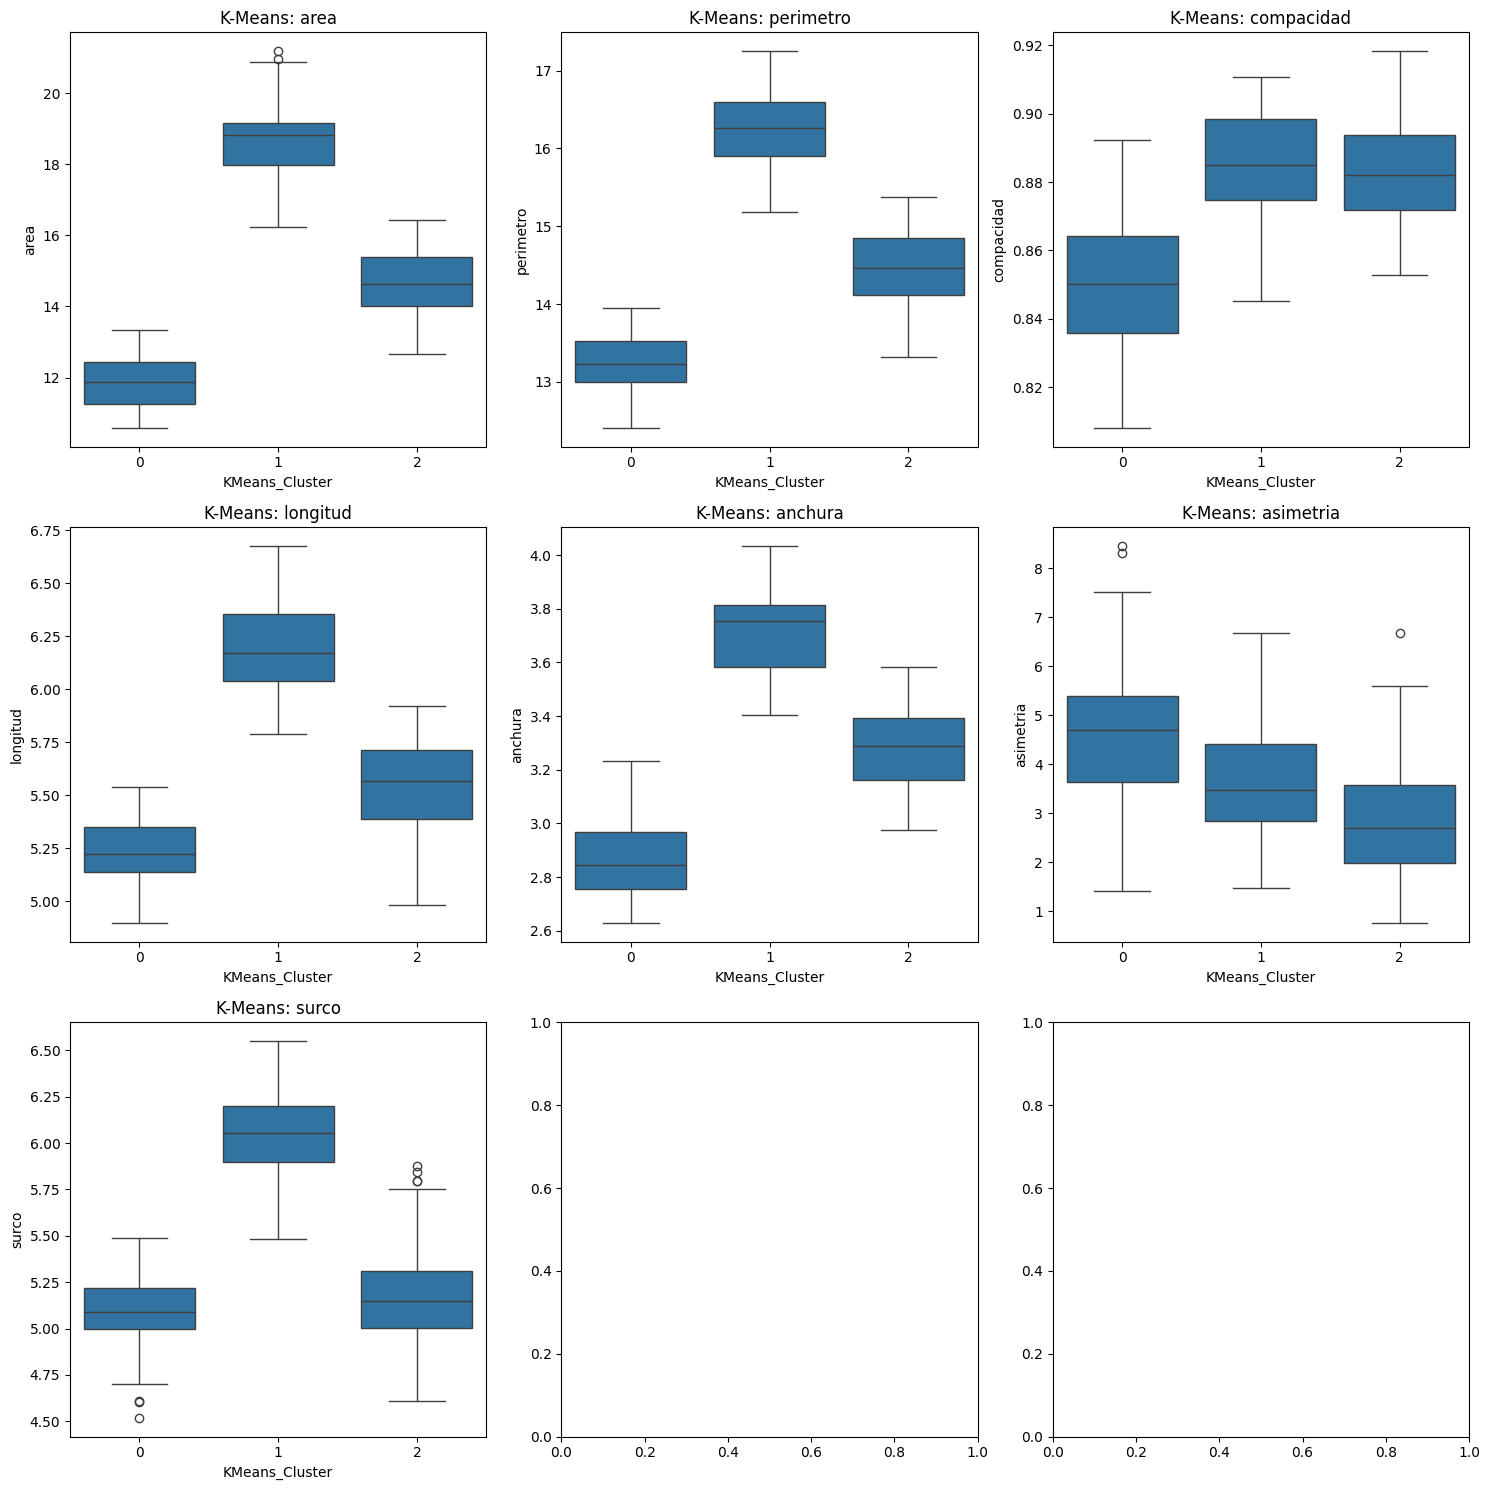


--- Boxplots de Variables Originales por Cluster Jerárquico ---


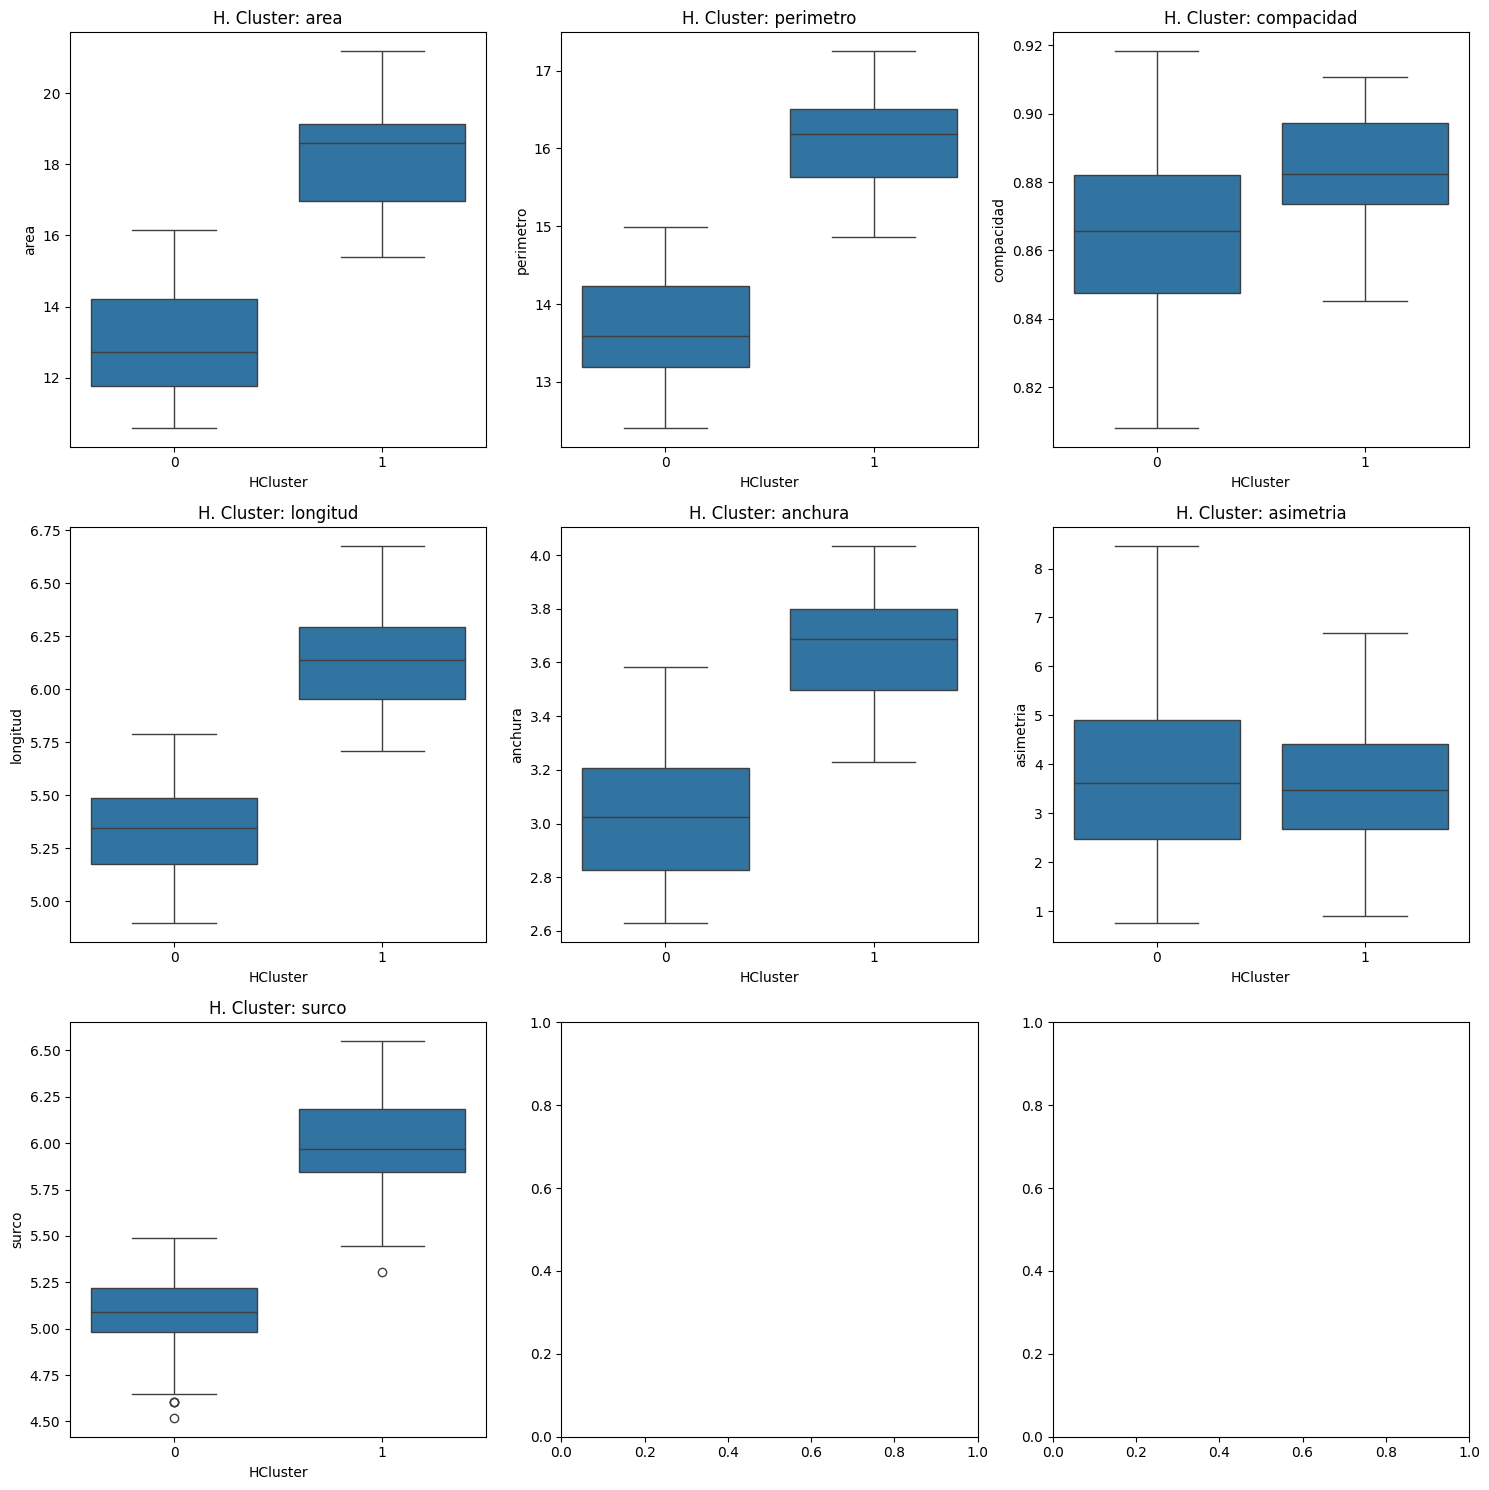


--- Boxplots de Variables Originales por Cluster de DBSCAN (sin ruido) ---


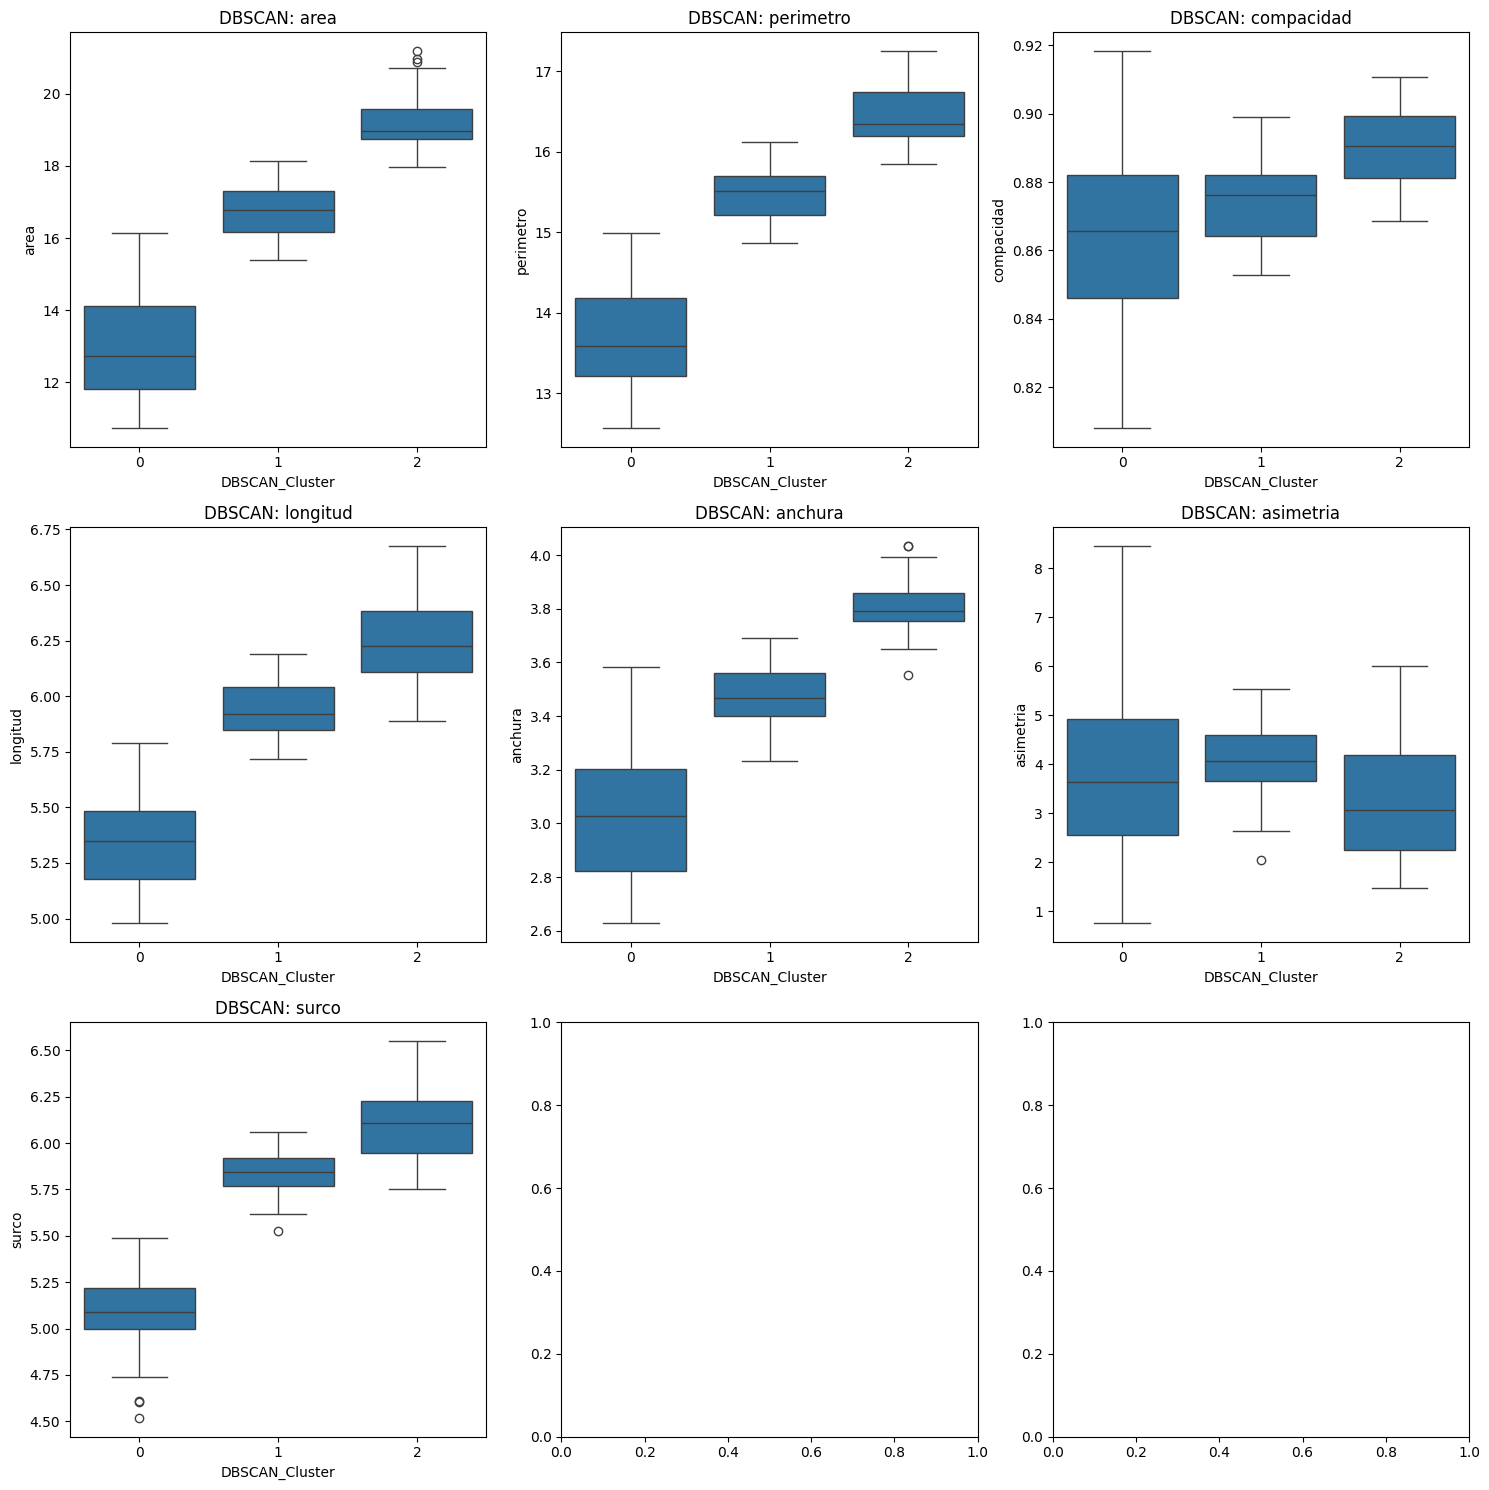


--- Boxplots de Variables Originales por Clase Original ---


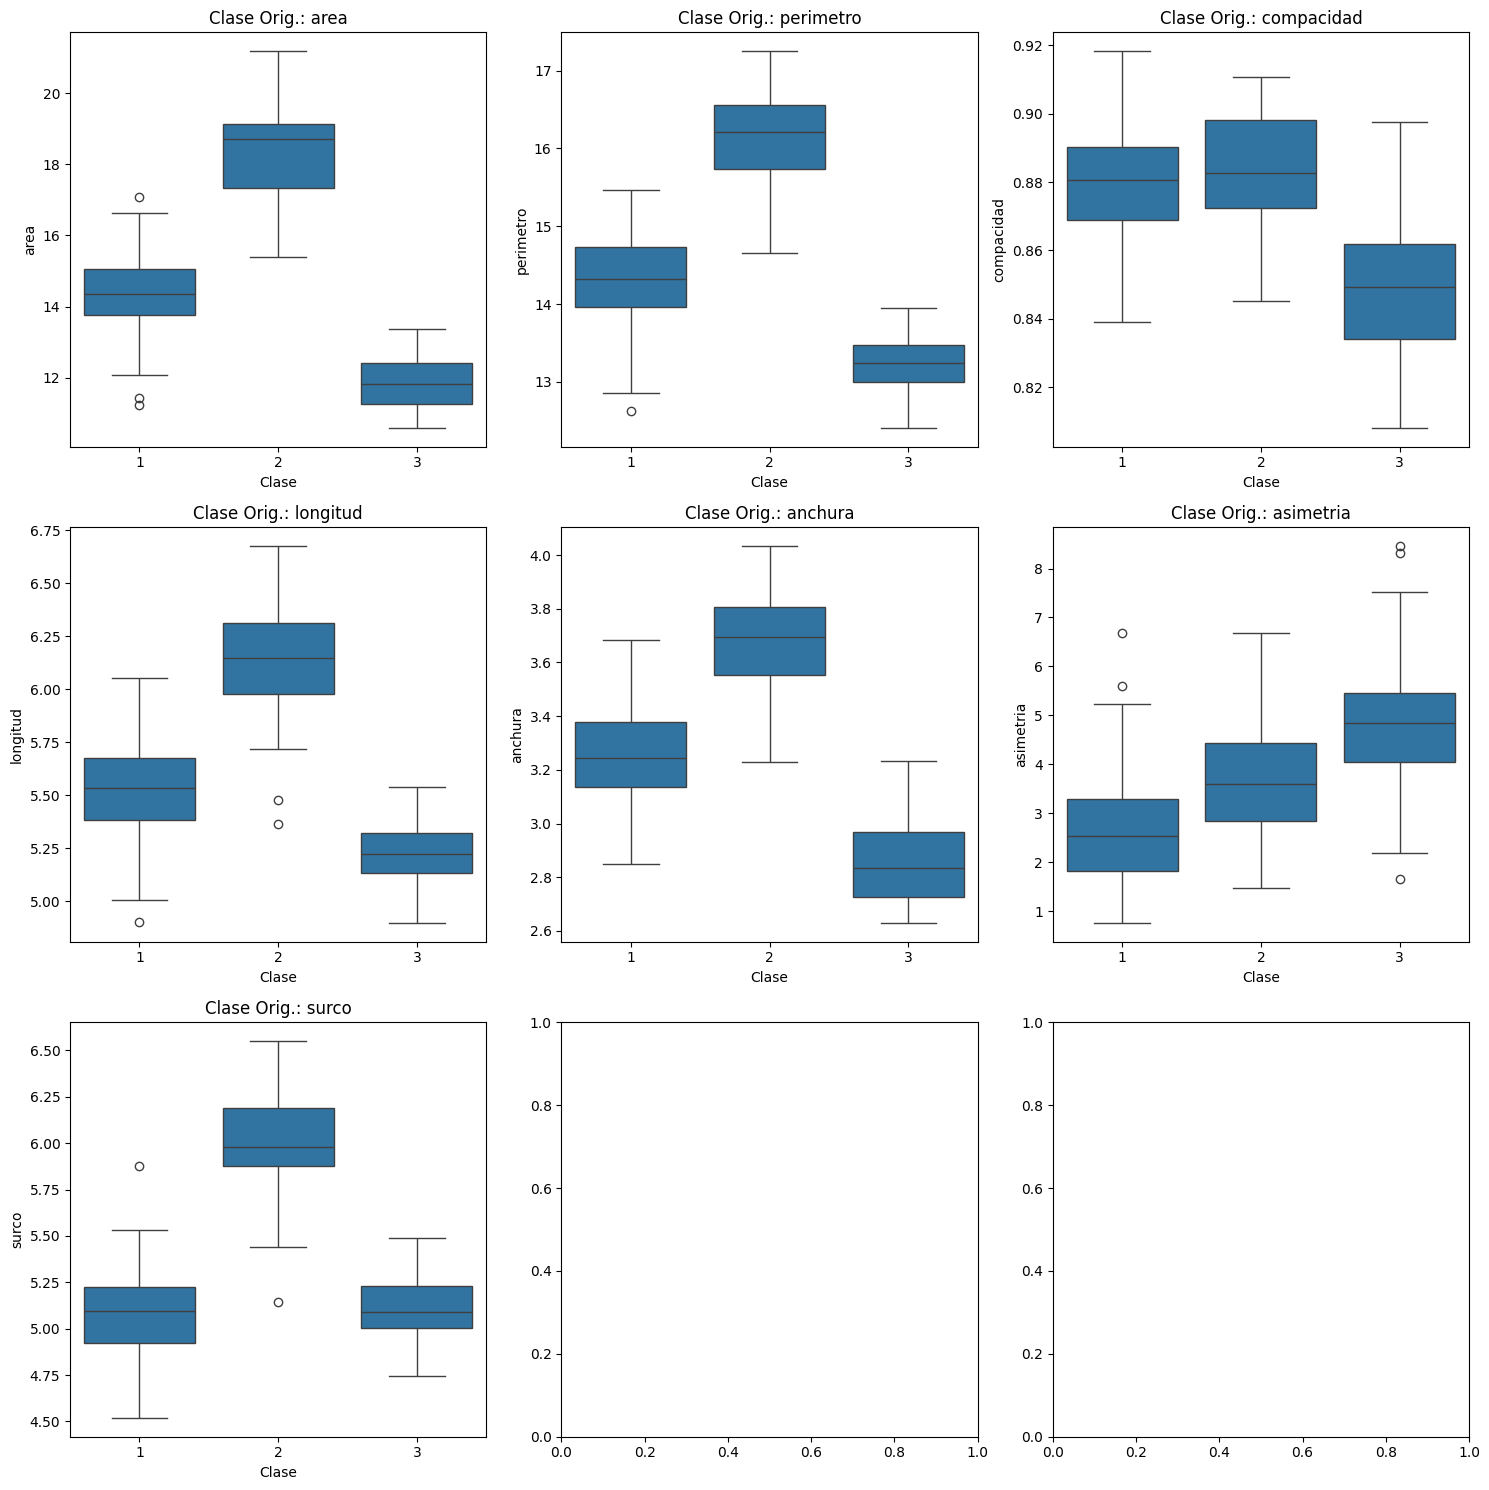

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que X es tu DataFrame o array NumPy original
# y que kmeans_labels, hclust_labels, dbscan_labels ya están definidos

# Lista con los nombres de las variables originales
feature_names = ["area", "perimetro", "compacidad", "longitud", "anchura", "asimetria", "surco"]
num_features = len(feature_names)
rows = (num_features + 2) // 3  # Calcular el número de filas necesarias para 3 columnas

# Crear un DataFrame con los datos originales y las etiquetas de los clusters
df_boxplot = pd.DataFrame(X, columns=feature_names)
df_boxplot['KMeans_Cluster'] = pd.Series(kmeans_labels, index=df_boxplot.index)
df_boxplot['HCluster'] = pd.Series(hclust_labels, index=df_boxplot.index)
df_boxplot['DBSCAN_Cluster'] = pd.Series(dbscan_labels, index=df_boxplot.index)
df_boxplot['Clase'] = pd.Series(Y, index=df_boxplot.index)

# Generar boxplots para cada variable original por cluster de K-Means
print("\n--- Boxplots de Variables Originales por Cluster de K-Means ---")
fig_kmeans, axes_kmeans = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes_kmeans = axes_kmeans.flatten()  # Para facilitar la indexación
for i, feature in enumerate(feature_names):
    sns.boxplot(x='KMeans_Cluster', y=feature, data=df_boxplot, ax=axes_kmeans[i])
    axes_kmeans[i].set_title(f'K-Means: {feature}')
plt.tight_layout()
plt.show()

# Generar boxplots para cada variable original por cluster Jerárquico
print("\n--- Boxplots de Variables Originales por Cluster Jerárquico ---")
fig_hclust, axes_hclust = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes_hclust = axes_hclust.flatten()
for i, feature in enumerate(feature_names):
    sns.boxplot(x='HCluster', y=feature, data=df_boxplot, ax=axes_hclust[i])
    axes_hclust[i].set_title(f'H. Cluster: {feature}')
plt.tight_layout()
plt.show()

# Generar boxplots para cada variable original por cluster de DBSCAN (sin ruido)
print("\n--- Boxplots de Variables Originales por Cluster de DBSCAN (sin ruido) ---")
df_dbscan_boxplot = df_boxplot[df_boxplot['DBSCAN_Cluster'] != -1]
fig_dbscan, axes_dbscan = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes_dbscan = axes_dbscan.flatten()
for i, feature in enumerate(feature_names):
    sns.boxplot(x='DBSCAN_Cluster', y=feature, data=df_dbscan_boxplot, ax=axes_dbscan[i])
    axes_dbscan[i].set_title(f'DBSCAN: {feature}')
plt.tight_layout()
plt.show()

# Generar boxplots para cada variable original por Clase Original
print("\n--- Boxplots de Variables Originales por Clase Original ---")
fig_original, axes_original = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes_original = axes_original.flatten()
for i, feature in enumerate(feature_names):
    sns.boxplot(x='Clase', y=feature, data=df_boxplot, ax=axes_original[i])
    axes_original[i].set_title(f'Clase Orig.: {feature}')
plt.tight_layout()
plt.show()

Ahora mediante boxplots vamos a interpretar los resultados obtenidos. Nos vamos a enfocar en cómo para cada cluster de una variable varía la mediana, si se superponen las cajas, la longitud de los bigotes y la cantidad de valores atípicos. Antes de empezar es importante recordar, que la longitud de los bigotes muestra qué tan distribuidos están los valores fuera del primer y tercer cuartil (la dispersión de estos datos), y qué valores son lo suficientemente distintos para ser outliers.

Para empezar es importante analizar los boxplots de las variables originales, para observar qué variables se solapan en los grupos iniciales, y buscar si lo mismo ocurre en el cluster. Al brevemente analizar esto gráficos, llegamos a la conclusión que hay dos variables que no se encuentran fuertemente diferenciadas por dos grupos especificos: surco y compacidad. Y hay una en la cuál los grupos coinciden un poco unos con otro: asimetría. Se espera que estas tres variables tengan un comportamiento similar en los clusters.

Vamos a empezar con el cluster de K-Means. Aquí se puede apreciar que para las variables "perimetro", "longitud", y "anchura"; las cajas no se superponen por lo que los clusters separan bien los grupos, y no existen valores atípicos (outliers). En la variable área, no se superponen las cajas pero existen un par de outliers, lo que muestra que es generalemente efectivo con la excepción de un par de valores. Para el resto de variables hay un superposición, en especial para el cluster 1 y 2 de "compacidad", y el cluster 0 y 2 de "surco". Esta situación muestra que los cluster no logran separar efectivamente estas variables. Sin embargo, estas variables tienen el mismo comportamiento en los gurpos originales, que los cluster hagan lo mismo son buenos reslutados.La variable "asimetría", muestra una pequeña superposición de las cajas entre clusters, pero esta diferenciación es muy similar en los grupos originales. Con esto, llegamos a la conclusión que este método crea clusters que en términos generales, separan bien los grupos. Las variables que se no se superponen por cluster tampoco lo hacen en los grupos originales, y las que se supeproponen, lo hacen de una forma realmente similar a los originales. En general los clusters están realizando un buen trabajo.


Para el método jerárquico llegamos a conclusiones distintas. Es importante resaltar, que este técnica fue más fácil de analizar ya que solo se debían comparar dos boxes (clusters) por variable. En este método encontramos 4 variables verdaderamente diferenciadas por cada cluster. En estas, los bigotes casi ni coincidieron, denotando que son realmente distintos los valores que se encuentran en ellos. Estos cuatro variables son: "área", "perimetro", "longitud" y "surco". Con esta última es importante resaltar la existencia de un par de outliers. A continuación tenemos la variable "anchura", en la cuál pese a que los bigotes se solapan un poco, las cajas siguen ampliamente separadas, mostrando que la diferenciación sigue siendo efectiva. En cuanto a las variables "asimetría" y "compacidad" se pueden encontrar ciertos porblemas. En "compacidad", tenemos los cuadros un poco solapados, sin embargo, no en una cantidad alarmante, se sigue observando cómo se diferencian. El problema viene a partir de los bigotes, los cuales para el primer cluster cubren toda el área de valores. Esta situación muestra que se pueden encontrar valores de todo tipo en el cluster, haciendolo menos eficiente para crear un grupo. Por el otro lado, la variable "asimetría" tiene cuadrados de rango intercuartílico paácticamente idénticos, lo que la hacen una variable muy perjudicial para crear clusters. Esto significa que la mayoría de valores de esta variable podrían estar en cualquiera de los dos clusters. Estos últimas dos variables son las que no están bien denotadas por el cluster, y son las menos claves para realizar esta separación. La variable "asimetría" y "compacidad" se comportan similar a los datos originales. Sin embargo, "surco" muestra diferenciación muy clara entre ambos clusters, algo que no ocurre con los grupos originales. Esto denota que los clusters creados no logran dividir los grupos como se espera en base a esta variable.

Finalmente se van a analizar los resultados obtenidos con el método DBSCAN. Aquín tenemos 5 variables que separan muy bien los valores entre los tres clusters. Entre ellas se encuentran: "área", "perimetro", "longitud", "anchura", y "surco". Todas estas, a excepción de "surco", realizan una diferenciación similar a los grupos originales. En relación la esta excepción, en los grupos originales no hay una clara diferenciación de valores en la variable "surco", se espera que en los cluster creados tampcoco la haya. Sin embargo, en este caso la diferenciaición es clara, lo que muestra que los clusters no pueden dividir correctamente en base a los valores de esta variable. En la variable "compacidad" se solapan intentamente las cajas dedos clusters, pero esto mismo ocurre con los grupos originales en esta variable, por lo que este comportamiento se esperaba que estuviese presente, y al estarlo muestra un buen trabajo de los clusters. Lo mismo ocurre con la variable "asimetría", en los datos originales se solapan brevemente la primer caja con la segunda y la segunda con la tercera. Se esperaba un comportamiento similar, y en este caso ocurrió pero con mayor magnitud, mostrando un solapamiento de las tres a la vez. Por ende, para esta variable la división no es tan acertada como debería, pero tiene un comportamiento relativamente similar.

En términos generales, se puede llegar a la conclusión que la mayoría de las variables fueron representadas de forma correcta por los cluster. Las diferenciadas en los grupos originales se vieron siempre diferenciadas por los clusters. Las variable "compacidad" y "asimetría", mostraban en los grupos originales que podían frecuentemente presentarse con mismo valor en varios grupos distintos, y fueron representadas de la misma forma en los clusters ("asimetría" un poco menos diferenciable que originalmente). La variable "surco", la cual también era difícil de diferenciar en los grupos originales, tuvo el mismo comportamiento en K-Means, pero en los otros métodos no fue representada correctamente (los clusters realizaon muy clara diferenciación). Para finalizar, nos gustaría resaltar que este análisis nos llevó a confimar que el método que más efectivamente separa estos datos es K-Means. En este método todas las variables fueron diferenciadas de una forma similar a como estaban divididas en las clases de semillas originales.